# Learning a quadratic prior

This code attempts to learn a concave quadratic prior $J(x) = -\frac{1}{4}||x||_2^2$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian $H(p) = \frac{1}{2}||p||_2^2$.
The LPN learns the function $\psi(x) = ||x||_2^2$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/concave_quadratic_prior_2D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

# === Section ===

In [2]:
# Parameters

dim_exp = 2  
data_points_exp = 20000 
iterations_exp_initial = 1 
iterations_exp_long = 500000 
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 100 # For plotting cross-sections


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers
eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def cvx_true_concave_quad(y_points): # y_points is N x dim
    """
    Computes the target function psi(y) = ||y||_2^2 for the given problem.
    """
    return euclid_norm_sq(y_points)

def prior_true_concave_quad(x_points):
    """
    Computes the true concave prior J(x) = -1/4 * ||x||_2^2.
    """
    return -0.25 * euclid_norm_sq(x_points)

def invert_prior_lpn(x, model, INVERT_MODE):
    y = invert(x,model,INVERT_MODE)
    return y

def evaluate_learned_prior_lpn(x_eval_points, y_inverted_points, model):
    try:
        y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
    except NameError: 
        print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
        y_tensor = torch.from_numpy(y_inverted_points).float()
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
    prior_est = inner_prod(x_eval_points, y_inverted_points) - 0.5 * euclid_norm_sq(x_eval_points) - psi_of_y_inverted
    return prior_est


def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    x1_0_psi_true = cvx_true_concave_quad(x1_0_points)
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_concave_quad(x2_0_points)
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else: 
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true
        
    x1_0_psi_est = cvx(x1_0_points, model) 
    y1_inverted = invert_prior_lpn(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_prior_lpn(x1_0_points,y1_inverted, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        y2_inverted = invert_prior_lpn(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_prior_lpn(x2_0_points,y2_inverted, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
        
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"$\\psi(y_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$",fontsize=16)
    plt.xlabel('$y_1$',fontsize=16)
    plt.ylabel('$\\psi(y_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2) # Second plot for psi if dim > 1
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"$\\psi(0,y_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$",fontsize=16)
        plt.xlabel('$y_2$',fontsize=16)
        plt.ylabel('$\\psi(0,y_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('$J(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('$J(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_concave_quad(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim={dim}) ---")
    cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim)



In [4]:
def evaluate_learned_H(model, a, spacing, dim):
    """
    Calculates and plots the approximate Hamiltonian H_theta.
    H_theta(p) = max_k { <p, eta_k> - b_k }
    where eta_k = x_k - grad_psi(x_k) and b_k = 0.5 * ||eta_k||^2
    """
    x_k_np = np.random.uniform(-a, a, (data_points_exp, dim))
    x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
    x_k_tensor.requires_grad_(True)
    grad_psi_k_tensor = model(x_k_tensor)

    eta_k_tensor = x_k_tensor - grad_psi_k_tensor
    b_k_tensor = 0.5 * torch.sum(eta_k_tensor**2, dim=1, keepdim=True)

    xi = np.linspace(-a, a, spacing)
    p_eval_points_np = np.zeros((xi.size, dim))
    p_eval_points_np[:, 0] = xi
    p_eval_tensor = torch.from_numpy(p_eval_points_np).float().to(device)

    # Compute H_theta(p) for the cross-section
    inner_prods = torch.matmul(p_eval_tensor, eta_k_tensor.T)  # (spacing x data_points)
    H_theta_p_tensor = torch.max(inner_prods - b_k_tensor.T, dim=1, keepdim=True)[0]
    H_theta_p_np = H_theta_p_tensor.detach().cpu().numpy().flatten()

    # Compute true Hamiltonian H(p) = 0.5 * ||p||^2
    H_true_p_np = 0.5 * euclid_norm_sq(p_eval_points_np)

    plt.figure(figsize=(6,5))
    plt.plot(xi, H_theta_p_np, "-", label="Learned Hamiltonian $H_{\\theta}(p_1,0,...)$")
    plt.plot(xi, H_true_p_np, "--", label="True Hamiltonian $H(p)=1/2||p||_2^2$")
    plt.grid(True)
    plt.title(f"Hamiltonian Comparison - Dim {dim}")
    plt.xlabel('$p_1$')
    plt.ylabel('H(p)')
    plt.legend()
    plt.tight_layout()
    plt.show()


# --- Generate Training Data

In [5]:
# --- Generate Training Data for the new experiment ---
print("--- Generating Training Data for Concave Quadratic Prior ---")
y_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))
psi_samples_exp_np = cvx_true_concave_quad(y_j_exp_np)
psi_samples_exp_np = psi_samples_exp_np.reshape(-1, 1)

y_j_exp_tensor = torch.from_numpy(y_j_exp_np).float().to(device)
psi_samples_exp_tensor = torch.from_numpy(psi_samples_exp_np).float().to(device)
print(f"Generated training data: y_j_exp_tensor shape {y_j_exp_tensor.shape}, psi_samples_exp_tensor shape {psi_samples_exp_tensor.shape}")

# --- ADD THIS TO MOVE DATA TO GPU ---
y_j_exp_tensor = y_j_exp_tensor.to(device)
psi_samples_exp_tensor = psi_samples_exp_tensor.to(device)

--- Generating Training Data for Concave Quadratic Prior ---


Generated training data: y_j_exp_tensor shape torch.Size([20000, 2]), psi_samples_exp_tensor shape torch.Size([20000, 1])


## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    #elif loss_type == 0:
    #    loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [7]:

# --- Train and Plot ---
print("\n--- Training LPN for Concave Quadratic Prior (Quadratic H) ---")
lpn_model_concave_quad_l2 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_concave_quad = torch.optim.Adam(lpn_model_concave_quad_l2.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_concave_quad.param_groups:
    g["lr"] = 1e-3
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_concave_quad.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_concave_quad_l2.state_dict(), os.path.join(MODEL_DIR, "ConcaveQuadraticH_l2.pth"))



--- Training LPN for Concave Quadratic Prior (Quadratic H) ---


iteration 0 loss 138.05557250976562
iteration 0 loss 956.4288940429688


iteration 500 loss 1.1512198448181152


iteration 1000 loss 0.07078554481267929


iteration 1500 loss 0.03850073739886284


iteration 2000 loss 0.024842876940965652


iteration 2500 loss 0.016623279079794884


iteration 3000 loss 0.014411702752113342


iteration 3500 loss 0.009535987861454487


iteration 4000 loss 0.0072062634862959385


iteration 4500 loss 0.005543692037463188


iteration 5000 loss 0.008520347066223621


iteration 5500 loss 0.0040974365547299385


iteration 6000 loss 0.0029898914508521557


iteration 6500 loss 0.0023359348997473717


iteration 7000 loss 0.0021743960678577423


iteration 7500 loss 0.0016178182559087873


iteration 8000 loss 0.0020772211719304323


iteration 8500 loss 0.0012903845636174083


iteration 9000 loss 0.0010083660017699003


iteration 9500 loss 0.0012554252753034234


iteration 10000 loss 0.0008315101149491966


iteration 10500 loss 0.0006520137540064752


iteration 11000 loss 0.0007041693315841258


iteration 11500 loss 0.0005321610369719565


iteration 12000 loss 0.0006918468279764056


iteration 12500 loss 0.0004565044364426285


iteration 13000 loss 0.0008468347368761897


iteration 13500 loss 0.0004027523973491043


iteration 14000 loss 0.07272003591060638


iteration 14500 loss 0.00032144601573236287


iteration 15000 loss 0.00031495298026129603


iteration 15500 loss 0.0003378510882612318


iteration 16000 loss 0.000443266675574705


iteration 16500 loss 0.0002497554523870349


iteration 17000 loss 0.0002722277713473886


iteration 17500 loss 0.0003533364797476679


iteration 18000 loss 0.0895114541053772


iteration 18500 loss 0.00018612953135743737


iteration 19000 loss 0.00018416190869174898


iteration 19500 loss 0.0001793702831491828


iteration 20000 loss 0.00018158864986617118


iteration 20500 loss 0.00024293303431477398


iteration 21000 loss 0.00014448455476667732


iteration 21500 loss 0.00014923872367944568


iteration 22000 loss 0.0001712411904009059


iteration 22500 loss 0.00012583746865857393


iteration 23000 loss 0.00013160635717213154


iteration 23500 loss 0.00017819757340475917


iteration 24000 loss 0.0001147967777797021


iteration 24500 loss 0.00012860700371675193


iteration 25000 loss 0.0001407157105859369


iteration 25500 loss 0.0002547947224229574


iteration 26000 loss 0.00010160866804653779


iteration 26500 loss 0.00012898283603135496


iteration 27000 loss 9.057616989593953e-05


iteration 27500 loss 0.0001048791891662404


iteration 28000 loss 0.00013904973457101732


iteration 28500 loss 8.827599958749488e-05


iteration 29000 loss 0.00012050766963511705


iteration 29500 loss 8.348889241460711e-05


iteration 30000 loss 0.00010041037603514269


iteration 30500 loss 0.00013047338870819658


iteration 31000 loss 8.220616291509941e-05


iteration 31500 loss 0.00010931167344097048


iteration 32000 loss 7.724623719695956e-05


iteration 32500 loss 9.821663843467832e-05


iteration 33000 loss 7.138575165299699e-05


iteration 33500 loss 9.471282101003453e-05


iteration 34000 loss 7.111710147000849e-05


iteration 34500 loss 8.313400758197531e-05


iteration 35000 loss 0.0006900029256939888


iteration 35500 loss 7.432530401274562e-05


iteration 36000 loss 0.00011286528024356812


iteration 36500 loss 6.83312609908171e-05


iteration 37000 loss 9.033714013639838e-05


iteration 37500 loss 6.428839697036892e-05


iteration 38000 loss 7.497870683437213e-05


iteration 38500 loss 0.00011625313345575705


iteration 39000 loss 6.204085366334766e-05


iteration 39500 loss 8.867452561389655e-05


iteration 40000 loss 5.931967461947352e-05


iteration 40500 loss 7.158066000556573e-05


iteration 41000 loss 0.0001440310152247548


iteration 41500 loss 5.817112833028659e-05


iteration 42000 loss 0.00013468983524944633


iteration 42500 loss 5.924216384300962e-05


iteration 43000 loss 0.019899986684322357


iteration 43500 loss 6.166469393065199e-05


iteration 44000 loss 4.944029205944389e-05


iteration 44500 loss 5.7812092563835904e-05


iteration 45000 loss 0.00010787303472170606


iteration 45500 loss 5.158339627087116e-05


iteration 46000 loss 7.759146683383733e-05


iteration 46500 loss 4.903049921267666e-05


iteration 47000 loss 8.059831452555954e-05


iteration 47500 loss 4.691517096944153e-05


iteration 48000 loss 5.388470890466124e-05


iteration 48500 loss 0.1098843514919281


iteration 49000 loss 4.8975503887049854e-05


iteration 49500 loss 7.091384759405628e-05


iteration 50000 loss 4.375903881737031e-05


iteration 50500 loss 6.130368274170905e-05


iteration 51000 loss 4.148247171542607e-05


iteration 51500 loss 4.978357901563868e-05


iteration 52000 loss 0.00015805439034011215


iteration 52500 loss 4.270435601938516e-05


iteration 53000 loss 4.990301022189669e-05


iteration 53500 loss 7.327533239731565e-05


iteration 54000 loss 0.00032026515691541135


iteration 54500 loss 4.140332748647779e-05


iteration 55000 loss 4.873622674494982e-05


iteration 55500 loss 9.557265002513304e-05


iteration 56000 loss 3.921766619896516e-05


iteration 56500 loss 5.187269925954752e-05


iteration 57000 loss 3.819302946794778e-05


iteration 57500 loss 4.127641295781359e-05


iteration 58000 loss 5.81021340622101e-05


iteration 58500 loss 8.03575967438519e-05


iteration 59000 loss 0.00021522202587220818


iteration 59500 loss 3.723111149156466e-05


iteration 60000 loss 3.844507591566071e-05


iteration 60500 loss 4.1647275793366134e-05


iteration 61000 loss 4.957123746862635e-05


iteration 61500 loss 0.00014638275024481118


iteration 62000 loss 3.762186679523438e-05


iteration 62500 loss 5.019631134928204e-05


iteration 63000 loss 3.352712155901827e-05


iteration 63500 loss 3.890208972734399e-05


iteration 64000 loss 4.987861757399514e-05


iteration 64500 loss 8.342649380210787e-05


iteration 65000 loss 3.453289900789969e-05


iteration 65500 loss 3.8878966734046116e-05


iteration 66000 loss 4.454061127034947e-05


iteration 66500 loss 4.892167271464132e-05


iteration 67000 loss 4.379805614007637e-05


iteration 67500 loss 0.0002641555620357394


iteration 68000 loss 3.52084098267369e-05


iteration 68500 loss 6.490505620604381e-05


iteration 69000 loss 3.406018004170619e-05


iteration 69500 loss 4.13011439377442e-05


iteration 70000 loss 3.005235703312792e-05


iteration 70500 loss 0.00016630192112643272


iteration 71000 loss 3.2599920814391226e-05


iteration 71500 loss 3.420285429456271e-05


iteration 72000 loss 6.943882181076333e-05


iteration 72500 loss 3.247986387577839e-05


iteration 73000 loss 4.814001658814959e-05


iteration 73500 loss 3.031341293535661e-05


iteration 74000 loss 3.289331289124675e-05


iteration 74500 loss 3.0632152629550546e-05


iteration 75000 loss 3.5334855056134984e-05


iteration 75500 loss 2.855578532034997e-05


iteration 76000 loss 3.099896275671199e-05


iteration 76500 loss 4.3007290514651686e-05


iteration 77000 loss 2.8427752113202587e-05


iteration 77500 loss 3.059596929233521e-05


iteration 78000 loss 3.999859472969547e-05


iteration 78500 loss 2.7511418011272326e-05


iteration 79000 loss 3.063536496483721e-05


iteration 79500 loss 7.931072468636557e-05


iteration 80000 loss 2.7048685296904296e-05


iteration 80500 loss 2.9394954253803007e-05


iteration 81000 loss 3.245552579755895e-05


iteration 81500 loss 0.0002643186307977885


iteration 82000 loss 2.5298331820522435e-05


iteration 82500 loss 2.7596019208431244e-05


iteration 83000 loss 0.0007148653967306018


iteration 83500 loss 2.497508830856532e-05


iteration 84000 loss 2.606961061246693e-05


iteration 84500 loss 2.91657979687443e-05


iteration 85000 loss 0.0004799595626536757


iteration 85500 loss 2.3448381398338825e-05


iteration 86000 loss 2.42193418671377e-05


iteration 86500 loss 2.617394238768611e-05


iteration 87000 loss 3.88702901545912e-05


iteration 87500 loss 2.256748302897904e-05


iteration 88000 loss 2.6370938940090127e-05


iteration 88500 loss 2.1462716176756658e-05


iteration 89000 loss 2.28957760555204e-05


iteration 89500 loss 2.8072085115127265e-05


iteration 90000 loss 2.124946695403196e-05


iteration 90500 loss 2.274682992720045e-05


iteration 91000 loss 2.8071182896383107e-05


iteration 91500 loss 2.057995880022645e-05


iteration 92000 loss 2.1346600988181308e-05


iteration 92500 loss 2.362061604799237e-05


iteration 93000 loss 0.019786423072218895


iteration 93500 loss 2.1055398974567652e-05


iteration 94000 loss 2.6526051442488097e-05


iteration 94500 loss 1.9841358152916655e-05


iteration 95000 loss 2.2008074665791355e-05


iteration 95500 loss 8.272015111288056e-05


iteration 96000 loss 1.9649531168397516e-05


iteration 96500 loss 2.0194280295982026e-05


iteration 97000 loss 2.280797707499005e-05


iteration 97500 loss 1.863743455032818e-05


iteration 98000 loss 2.0122388377785683e-05


iteration 98500 loss 2.4347320504602976e-05


iteration 99000 loss 1.8413367797620595e-05


iteration 99500 loss 1.9458217138890177e-05


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 2.167992715840228e-05


iteration 100500 loss 2.0793679141206667e-05


iteration 101000 loss 1.9983401216450147e-05


iteration 101500 loss 1.92489806067897e-05


iteration 102000 loss 1.858335963333957e-05


iteration 102500 loss 1.796874130377546e-05


iteration 103000 loss 1.736849117150996e-05


iteration 103500 loss 1.6752850569901057e-05


iteration 104000 loss 1.610210347280372e-05


iteration 104500 loss 1.5403235011035576e-05


iteration 105000 loss 1.4662596186099108e-05


iteration 105500 loss 1.4201323210727423e-05


iteration 106000 loss 1.4857545465929434e-05


iteration 106500 loss 1.3253363249532413e-05


iteration 107000 loss 1.2842868272855412e-05


iteration 107500 loss 0.00047972725587897


iteration 108000 loss 1.2131567018514033e-05


iteration 108500 loss 1.1803461347881239e-05


iteration 109000 loss 1.153405992226908e-05


iteration 109500 loss 1.1245608220633585e-05


iteration 110000 loss 1.0988622307195328e-05


iteration 110500 loss 1.0766130799311213e-05


iteration 111000 loss 1.0528400707698893e-05


iteration 111500 loss 1.0292671504430473e-05


iteration 112000 loss 1.0101982297783252e-05


iteration 112500 loss 9.930491614795756e-06


iteration 113000 loss 9.717094144434668e-06


iteration 113500 loss 9.556947588862386e-06


iteration 114000 loss 9.364382094645407e-06


iteration 114500 loss 9.225634130416438e-06


iteration 115000 loss 9.221738764608745e-06


iteration 115500 loss 8.902059562387876e-06


iteration 116000 loss 8.767195140535478e-06


iteration 116500 loss 8.627952411188744e-06


iteration 117000 loss 8.607927156845108e-06


iteration 117500 loss 8.34282036521472e-06


iteration 118000 loss 8.218622497224715e-06


iteration 118500 loss 8.097546924545895e-06


iteration 119000 loss 7.976941560627893e-06


iteration 119500 loss 7.859672223275993e-06


iteration 120000 loss 7.731804544164333e-06


iteration 120500 loss 7.618783001817064e-06


iteration 121000 loss 7.514369826822076e-06


iteration 121500 loss 7.414755145873642e-06


iteration 122000 loss 7.318361440411536e-06


iteration 122500 loss 7.216080120997503e-06


iteration 123000 loss 7.1288077378994785e-06


iteration 123500 loss 3.5607201425591484e-05


iteration 124000 loss 6.936147656233516e-06


iteration 124500 loss 6.8696394919243176e-06


iteration 125000 loss 6.7711648625845555e-06


iteration 125500 loss 6.7008718360739294e-06


iteration 126000 loss 6.6327452259429265e-06


iteration 126500 loss 6.544492862303741e-06


iteration 127000 loss 6.480107913375832e-06


iteration 127500 loss 6.394466709025437e-06


iteration 128000 loss 6.331307304208167e-06


iteration 128500 loss 6.268258402997162e-06


iteration 129000 loss 6.188373845361639e-06


iteration 129500 loss 6.12785197517951e-06


iteration 130000 loss 6.302720976236742e-06


iteration 130500 loss 6.001476322126109e-06


iteration 131000 loss 7.0197429522522725e-06


iteration 131500 loss 5.882444384042174e-06


iteration 132000 loss 5.824388608743902e-06


iteration 132500 loss 0.001091164886020124


iteration 133000 loss 5.69800704397494e-06


iteration 133500 loss 5.64325591767556e-06


iteration 134000 loss 5.591681201622123e-06


iteration 134500 loss 1.4055404790269677e-05


iteration 135000 loss 5.474489171319874e-06


iteration 135500 loss 5.424051778391004e-06


iteration 136000 loss 5.37114010512596e-06


iteration 136500 loss 5.323728601069888e-06


iteration 137000 loss 5.276977844914654e-06


iteration 137500 loss 5.222907475399552e-06


iteration 138000 loss 5.172380497242557e-06


iteration 138500 loss 5.127788426761981e-06


iteration 139000 loss 5.084977146907477e-06


iteration 139500 loss 5.180077550903661e-06


iteration 140000 loss 4.986342446500203e-06


iteration 140500 loss 4.9426212171965744e-06


iteration 141000 loss 4.9015861804946326e-06


iteration 141500 loss 4.861608431383502e-06


iteration 142000 loss 5.91013895245851e-06


iteration 142500 loss 4.7728117351653054e-06


iteration 143000 loss 4.737230938189896e-06


iteration 143500 loss 4.699044438893907e-06


iteration 144000 loss 4.664152129407739e-06


iteration 144500 loss 5.515929842658807e-06


iteration 145000 loss 4.576956143864663e-06


iteration 145500 loss 4.540540430753026e-06


iteration 146000 loss 4.5067899918649346e-06


iteration 146500 loss 4.4733696995535865e-06


iteration 147000 loss 5.615316240437096e-06


iteration 147500 loss 4.395373707666295e-06


iteration 148000 loss 4.364875167084392e-06


iteration 148500 loss 4.333941888035042e-06


iteration 149000 loss 4.293461188353831e-06


iteration 149500 loss 4.263299615558935e-06


iteration 150000 loss 4.235579126543598e-06


iteration 150500 loss 2.6408672056277283e-05


iteration 151000 loss 4.167967290413799e-06


iteration 151500 loss 4.1402836359338835e-06


iteration 152000 loss 4.112696387892356e-06


iteration 152500 loss 4.115981028007809e-06


iteration 153000 loss 4.102178991161054e-06


iteration 153500 loss 4.018053914478514e-06


iteration 154000 loss 3.992987331002951e-06


iteration 154500 loss 4.726206498162355e-06


iteration 155000 loss 3.932713298127055e-06


iteration 155500 loss 3.909962742909556e-06


iteration 156000 loss 3.884950274368748e-06


iteration 156500 loss 4.181515032541938e-05


iteration 157000 loss 3.825194198725512e-06


iteration 157500 loss 3.8069247239036486e-06


iteration 158000 loss 3.7732811506430153e-06


iteration 158500 loss 3.7555805647571106e-06


iteration 159000 loss 3.7243291899358155e-06


iteration 159500 loss 3.7057384361105505e-06


iteration 160000 loss 5.418743057816755e-06


iteration 160500 loss 3.6578826438926626e-06


iteration 161000 loss 3.6782651022804203e-06


iteration 161500 loss 3.6138053474132903e-06


iteration 162000 loss 4.908348273602314e-05


iteration 162500 loss 3.5721445783565287e-06


iteration 163000 loss 3.542066679074196e-06


iteration 163500 loss 3.5316249977768166e-06


iteration 164000 loss 3.5027062494918937e-06


iteration 164500 loss 3.487883077468723e-06


iteration 165000 loss 3.460134848864982e-06


iteration 165500 loss 3.448967618169263e-06


iteration 166000 loss 3.4207719181722496e-06


iteration 166500 loss 3.408485554245999e-06


iteration 167000 loss 3.3819801501522306e-06


iteration 167500 loss 3.366242253832752e-06


iteration 168000 loss 3.3380208606104134e-06


iteration 168500 loss 3.3317733141302597e-06


iteration 169000 loss 3.3062992770283017e-06


iteration 169500 loss 3.29590511682909e-06


iteration 170000 loss 3.270117758802371e-06


iteration 170500 loss 3.2568636925134342e-06


iteration 171000 loss 3.231322352803545e-06


iteration 171500 loss 3.2147031561180484e-06


iteration 172000 loss 3.20531125908019e-06


iteration 172500 loss 3.1788379146746593e-06


iteration 173000 loss 3.164213012496475e-06


iteration 173500 loss 3.1396577924169833e-06


iteration 174000 loss 3.1273814329324523e-06


iteration 174500 loss 3.1147333174885716e-06


iteration 175000 loss 3.0874887215759372e-06


iteration 175500 loss 3.0716794299223693e-06


iteration 176000 loss 3.0573230560548836e-06


iteration 176500 loss 3.0376281756616663e-06


iteration 177000 loss 3.0224910005927086e-06


iteration 177500 loss 3.064194288526778e-06


iteration 178000 loss 2.9829377581336303e-06


iteration 178500 loss 2.971294179587858e-06


iteration 179000 loss 2.9577106488432037e-06


iteration 179500 loss 2.9348723273869837e-06


iteration 180000 loss 2.921859959315043e-06


iteration 180500 loss 2.9075304155412596e-06


iteration 181000 loss 2.893699956985074e-06


iteration 181500 loss 1.722833803796675e-05


iteration 182000 loss 2.8588640361704165e-06


iteration 182500 loss 2.846118604793446e-06


iteration 183000 loss 2.832952077369555e-06


iteration 183500 loss 8.707764209248126e-05


iteration 184000 loss 2.7971168492513243e-06


iteration 184500 loss 2.783581521725864e-06


iteration 185000 loss 2.7715593660104787e-06


iteration 185500 loss 2.7582368602452334e-06


iteration 186000 loss 3.3861665542644914e-06


iteration 186500 loss 6.536055934702745e-06


iteration 187000 loss 3.2779275898064952e-06


iteration 187500 loss 2.6964712560584303e-06


iteration 188000 loss 2.6832135517906863e-06


iteration 188500 loss 2.669712557690218e-06


iteration 189000 loss 2.65721700998256e-06


iteration 189500 loss 2.6450677523826016e-06


iteration 190000 loss 2.6505608730076347e-06


iteration 190500 loss 5.197733571549179e-06


iteration 191000 loss 2.60062915913295e-06


iteration 191500 loss 2.590381200207048e-06


iteration 192000 loss 2.576673978182953e-06


iteration 192500 loss 2.5653614557086257e-06


iteration 193000 loss 2.574658992671175e-06


iteration 193500 loss 9.761308319866657e-06


iteration 194000 loss 2.523647253838135e-06


iteration 194500 loss 2.5157305572065525e-06


iteration 195000 loss 2.5050092062883778e-06


iteration 195500 loss 2.4870303150237305e-06


iteration 196000 loss 2.4791108899080427e-06


iteration 196500 loss 2.469704895702307e-06


iteration 197000 loss 2.452965873089852e-06


iteration 197500 loss 2.4448677322652657e-06


iteration 198000 loss 2.433982217553421e-06


iteration 198500 loss 2.429085725452751e-06


iteration 199000 loss 2.4093524189083837e-06


iteration 199500 loss 2.3991058242245344e-06


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 2.390052259215736e-06


iteration 200500 loss 2.3883151243353495e-06


iteration 201000 loss 2.386358801231836e-06


iteration 201500 loss 2.38373945649073e-06


iteration 202000 loss 2.380398882451118e-06


iteration 202500 loss 2.376336624365649e-06


iteration 203000 loss 2.3712295842415188e-06


iteration 203500 loss 2.364665533605148e-06


iteration 204000 loss 2.3564234652440064e-06


iteration 204500 loss 2.3461664113710867e-06


iteration 205000 loss 2.3330251224251697e-06


iteration 205500 loss 2.3226245957630454e-06


iteration 206000 loss 2.311761363671394e-06


iteration 206500 loss 3.8020773445168743e-06


iteration 207000 loss 2.289342546646367e-06


iteration 207500 loss 2.2778299353376497e-06


iteration 208000 loss 2.267457375637605e-06


iteration 208500 loss 2.2579911274078768e-06


iteration 209000 loss 2.2463138975581387e-06


iteration 209500 loss 2.236351292594918e-06


iteration 210000 loss 2.2270653516898165e-06


iteration 210500 loss 2.2155149963509757e-06


iteration 211000 loss 2.2066176370572066e-06


iteration 211500 loss 2.197307139795157e-06


iteration 212000 loss 2.18551758734975e-06


iteration 212500 loss 2.1773698790639173e-06


iteration 213000 loss 2.167397269658977e-06


iteration 213500 loss 2.1570715489360737e-06


iteration 214000 loss 2.1482280772033846e-06


iteration 214500 loss 2.1377265966293635e-06


iteration 215000 loss 2.1291637040121714e-06


iteration 215500 loss 2.120142653438961e-06


iteration 216000 loss 6.202925305842655e-06


iteration 216500 loss 2.1016796836192952e-06


iteration 217000 loss 2.092218437610427e-06


iteration 217500 loss 2.0827367279707687e-06


iteration 218000 loss 2.0747077087435173e-06


iteration 218500 loss 2.0648374174925266e-06


iteration 219000 loss 2.056952553175506e-06


iteration 219500 loss 2.0487509573285934e-06


iteration 220000 loss 2.0384695744724013e-06


iteration 220500 loss 2.0313582353992388e-06


iteration 221000 loss 2.0227562345098704e-06


iteration 221500 loss 2.0137872525083367e-06


iteration 222000 loss 2.006172508117743e-06


iteration 222500 loss 1.996908395085484e-06


iteration 223000 loss 1.989359361687093e-06


iteration 223500 loss 1.9816600342892343e-06


iteration 224000 loss 1.9722026536328485e-06


iteration 224500 loss 1.965183628271916e-06


iteration 225000 loss 1.9566755327105056e-06


iteration 225500 loss 1.9487342797219753e-06


iteration 226000 loss 1.941344407896395e-06


iteration 226500 loss 1.939884441526374e-06


iteration 227000 loss 1.923433501360705e-06


iteration 227500 loss 1.91686717698758e-06


iteration 228000 loss 1.909060074467561e-06


iteration 228500 loss 1.9009980860573705e-06


iteration 229000 loss 1.8935236312245252e-06


iteration 229500 loss 1.8856458154914435e-06


iteration 230000 loss 1.8786489590638666e-06


iteration 230500 loss 1.869951120170299e-06


iteration 231000 loss 1.8638971823747852e-06


iteration 231500 loss 1.857459551501961e-06


iteration 232000 loss 1.8492945628167945e-06


iteration 232500 loss 1.8432210708851926e-06


iteration 233000 loss 1.836131787058548e-06


iteration 233500 loss 1.8292143977305386e-06


iteration 234000 loss 1.8222036715087597e-06


iteration 234500 loss 1.8142405906473869e-06


iteration 235000 loss 1.807862417990691e-06


iteration 235500 loss 1.8001899206865346e-06


iteration 236000 loss 1.7941320038517006e-06


iteration 236500 loss 1.7872396256279899e-06


iteration 237000 loss 1.7803042737796204e-06


iteration 237500 loss 1.7740073872118955e-06


iteration 238000 loss 3.771845058508916e-06


iteration 238500 loss 1.7610934719414217e-06


iteration 239000 loss 1.7540924091008492e-06


iteration 239500 loss 1.7477917708674795e-06


iteration 240000 loss 1.741964752000058e-06


iteration 240500 loss 1.7347532548228628e-06


iteration 241000 loss 1.7287991340708686e-06


iteration 241500 loss 1.7214380250152317e-06


iteration 242000 loss 1.7163700931632775e-06


iteration 242500 loss 1.7101142475439701e-06


iteration 243000 loss 1.703728457869147e-06


iteration 243500 loss 1.6976523511402775e-06


iteration 244000 loss 1.6915015521590249e-06


iteration 244500 loss 1.6856969295986346e-06


iteration 245000 loss 1.678877652011579e-06


iteration 245500 loss 1.6736485122237355e-06


iteration 246000 loss 1.6673562868163572e-06


iteration 246500 loss 1.6619230791548034e-06


iteration 247000 loss 1.656549329709378e-06


iteration 247500 loss 1.6499595858476823e-06


iteration 248000 loss 1.6447938833152875e-06


iteration 248500 loss 1.6386655943279038e-06


iteration 249000 loss 1.6334041674781474e-06


iteration 249500 loss 1.627972892492835e-06


iteration 250000 loss 1.6263272755168146e-06


iteration 250500 loss 1.617124212316412e-06


iteration 251000 loss 1.6112371667986736e-06


iteration 251500 loss 1.6061225096564158e-06


iteration 252000 loss 1.6011979369068285e-06


iteration 252500 loss 1.5951055729601649e-06


iteration 253000 loss 1.5905907275737263e-06


iteration 253500 loss 1.585559175509843e-06


iteration 254000 loss 2.039318360402831e-06


iteration 254500 loss 1.5750899819977349e-06


iteration 255000 loss 1.5692902479713666e-06


iteration 255500 loss 1.5646257907064864e-06


iteration 256000 loss 1.5598734535160474e-06


iteration 256500 loss 1.5538093975919764e-06


iteration 257000 loss 1.5499565506615909e-06


iteration 257500 loss 1.545016289128398e-06


iteration 258000 loss 1.5432963209605077e-06


iteration 258500 loss 1.5354409015344572e-06


iteration 259000 loss 1.5303339750971645e-06


iteration 259500 loss 1.5256242704708711e-06


iteration 260000 loss 1.5208822787826648e-06


iteration 260500 loss 1.515228177595418e-06


iteration 261000 loss 1.5114186453502043e-06


iteration 261500 loss 1.5065277239045827e-06


iteration 262000 loss 1.5017469650047133e-06


iteration 262500 loss 1.4975699968999834e-06


iteration 263000 loss 1.4924800098015112e-06


iteration 263500 loss 1.4881469496685895e-06


iteration 264000 loss 1.4836176660537603e-06


iteration 264500 loss 1.5066103742356063e-06


iteration 265000 loss 1.4746639180884813e-06


iteration 265500 loss 1.4697761798743159e-06


iteration 266000 loss 1.465558398194844e-06


iteration 266500 loss 1.461283432035998e-06


iteration 267000 loss 2.4256283722934313e-05


iteration 267500 loss 1.452617993891181e-06


iteration 268000 loss 1.448113948754326e-06


iteration 268500 loss 1.4437738400374656e-06


iteration 269000 loss 1.439802190361661e-06


iteration 269500 loss 1.4349938055602252e-06


iteration 270000 loss 1.431296368537005e-06


iteration 270500 loss 1.4272649195845588e-06


iteration 271000 loss 1.4224042388377711e-06


iteration 271500 loss 1.4188691466188175e-06


iteration 272000 loss 1.4145260820441763e-06


iteration 272500 loss 1.4104294905337156e-06


iteration 273000 loss 1.4065064988244558e-06


iteration 273500 loss 1.401787585564307e-06


iteration 274000 loss 1.3983370763526182e-06


iteration 274500 loss 1.3945527825853787e-06


iteration 275000 loss 1.3896776636102004e-06


iteration 275500 loss 1.3866914514437667e-06


iteration 276000 loss 1.3826286249241093e-06


iteration 276500 loss 1.3791767514703679e-06


iteration 277000 loss 1.3751392771155224e-06


iteration 277500 loss 1.37109316256101e-06


iteration 278000 loss 1.367215645586839e-06


iteration 278500 loss 1.363748083349492e-06


iteration 279000 loss 1.3595064274340984e-06


iteration 279500 loss 1.355991685159097e-06


iteration 280000 loss 1.3522339941118844e-06


iteration 280500 loss 1.492841875005979e-06


iteration 281000 loss 1.3450081723931362e-06


iteration 281500 loss 1.3410002566160983e-06


iteration 282000 loss 1.3374057061810163e-06


iteration 282500 loss 1.3338686812858214e-06


iteration 283000 loss 1.3297199075168464e-06


iteration 283500 loss 1.326528149547812e-06


iteration 284000 loss 1.323018977927859e-06


iteration 284500 loss 1.6401338598370785e-06


iteration 285000 loss 1.3160856724425685e-06


iteration 285500 loss 1.3123890312272124e-06


iteration 286000 loss 1.3089085086903651e-06


iteration 286500 loss 1.3054907412879402e-06


iteration 287000 loss 1.3013891475566197e-06


iteration 287500 loss 1.298312668041035e-06


iteration 288000 loss 1.2945918115292443e-06


iteration 288500 loss 1.2912349802718381e-06


iteration 289000 loss 1.287976942876412e-06


iteration 289500 loss 1.2839585679103038e-06


iteration 290000 loss 1.2810832004106487e-06


iteration 290500 loss 1.2774617061950266e-06


iteration 291000 loss 1.274360329261981e-06


iteration 291500 loss 1.2710678447547252e-06


iteration 292000 loss 1.7156535250251181e-06


iteration 292500 loss 1.2644533171624062e-06


iteration 293000 loss 1.2608821862158948e-06


iteration 293500 loss 1.2577185088957776e-06


iteration 294000 loss 1.2545474419312086e-06


iteration 294500 loss 1.93011260307685e-06


iteration 295000 loss 1.2481715430112672e-06


iteration 295500 loss 1.2447301287465962e-06


iteration 296000 loss 1.2417472134984564e-06


iteration 296500 loss 1.2385831951178261e-06


iteration 297000 loss 1.2348299378572847e-06


iteration 297500 loss 1.2322461770963855e-06


iteration 298000 loss 1.2289636970308493e-06


iteration 298500 loss 1.226037738888408e-06


iteration 299000 loss 1.2230824495418346e-06


iteration 299500 loss 1.2194207101856591e-06


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 1.2169343790446874e-06


iteration 300500 loss 1.2166585747763747e-06


iteration 301000 loss 1.2162922757852357e-06


iteration 301500 loss 1.2158842537246528e-06


iteration 302000 loss 1.2152228237027884e-06


iteration 302500 loss 1.2144492984589306e-06


iteration 303000 loss 1.2134156577303656e-06


iteration 303500 loss 1.2120624433009652e-06


iteration 304000 loss 1.2103403150831582e-06


iteration 304500 loss 1.2080981832696125e-06


iteration 305000 loss 1.2052016700181412e-06


iteration 305500 loss 1.2034024621243589e-06


iteration 306000 loss 1.1993156476819422e-06


iteration 306500 loss 1.1962897588091437e-06


iteration 307000 loss 1.1929676020372426e-06


iteration 307500 loss 1.1908633723578532e-06


iteration 308000 loss 1.1881123782586656e-06


iteration 308500 loss 1.1845957033074228e-06


iteration 309000 loss 1.1823931345134042e-06


iteration 309500 loss 1.1799929779954255e-06


iteration 310000 loss 1.1768562444558484e-06


iteration 310500 loss 1.17404590582737e-06


iteration 311000 loss 1.171908820651879e-06


iteration 311500 loss 1.1690798373820144e-06


iteration 312000 loss 1.1709125828929245e-06


iteration 312500 loss 1.1638002206382225e-06


iteration 313000 loss 1.1614406503213104e-06


iteration 313500 loss 1.1584174899326172e-06


iteration 314000 loss 1.1555088121895096e-06


iteration 314500 loss 1.1535976227605715e-06


iteration 315000 loss 1.1511211823744816e-06


iteration 315500 loss 1.1479468184916186e-06


iteration 316000 loss 1.1456093034212245e-06


iteration 316500 loss 1.143617396337504e-06


iteration 317000 loss 1.1410460274419165e-06


iteration 317500 loss 1.1376777138139005e-06


iteration 318000 loss 1.1358832807673025e-06


iteration 318500 loss 1.1337049272697186e-06


iteration 319000 loss 1.1308179637126159e-06


iteration 319500 loss 1.1280202443231246e-06


iteration 320000 loss 1.1261262216066825e-06


iteration 320500 loss 1.1237401622565812e-06


iteration 321000 loss 1.120604679272219e-06


iteration 321500 loss 1.1185254606971284e-06


iteration 322000 loss 1.1164793249918148e-06


iteration 322500 loss 1.1138399713672698e-06


iteration 323000 loss 1.1109561910416232e-06


iteration 323500 loss 1.1092174645455088e-06


iteration 324000 loss 1.1070387699874118e-06


iteration 324500 loss 1.1041386187571334e-06


iteration 325000 loss 1.1018777286153636e-06


iteration 325500 loss 1.0999428923241794e-06


iteration 326000 loss 1.0973366215694114e-06


iteration 326500 loss 1.0945722124233725e-06


iteration 327000 loss 1.092900106414163e-06


iteration 327500 loss 1.0907992873399053e-06


iteration 328000 loss 1.0880257832468487e-06


iteration 328500 loss 1.0858258292500977e-06


iteration 329000 loss 1.0839620472324896e-06


iteration 329500 loss 1.0815570021804888e-06


iteration 330000 loss 1.0806860473167035e-06


iteration 330500 loss 1.0770803555715247e-06


iteration 331000 loss 1.075098793990037e-06


iteration 331500 loss 1.0724662615757552e-06


iteration 332000 loss 1.0700343864300521e-06


iteration 332500 loss 1.0683394293664605e-06


iteration 333000 loss 1.0661750593499164e-06


iteration 333500 loss 1.0633649480951135e-06


iteration 334000 loss 1.0617611678753747e-06


iteration 334500 loss 1.0597727850836236e-06


iteration 335000 loss 1.0572777000561473e-06


iteration 335500 loss 1.0549820217420347e-06


iteration 336000 loss 1.0533591421335586e-06


iteration 336500 loss 1.051305616783793e-06


iteration 337000 loss 1.0486255632713437e-06


iteration 337500 loss 1.046859210873663e-06


iteration 338000 loss 1.0450924037286313e-06


iteration 338500 loss 1.0428037739984575e-06


iteration 339000 loss 1.0403060741737136e-06


iteration 339500 loss 1.0388139344286174e-06


iteration 340000 loss 1.0369332130721887e-06


iteration 340500 loss 1.0344907650505775e-06


iteration 341000 loss 1.0324171171305352e-06


iteration 341500 loss 1.0307613820259576e-06


iteration 342000 loss 1.028699330163363e-06


iteration 342500 loss 1.026840322992939e-06


iteration 343000 loss 1.0246992587781278e-06


iteration 343500 loss 1.0228122846456245e-06


iteration 344000 loss 1.0203963256572024e-06


iteration 344500 loss 1.0186699910263997e-06


iteration 345000 loss 1.016779037854576e-06


iteration 345500 loss 1.01426746823563e-06


iteration 346000 loss 1.0125871767741046e-06


iteration 346500 loss 1.0109454251505667e-06


iteration 347000 loss 1.0088821227327571e-06


iteration 347500 loss 1.006507432066428e-06


iteration 348000 loss 1.0051078334072372e-06


iteration 348500 loss 1.003317947834148e-06


iteration 349000 loss 1.0010687674366636e-06


iteration 349500 loss 9.99086751107825e-07


iteration 350000 loss 9.976649835152784e-07


iteration 350500 loss 9.958637292584172e-07


iteration 351000 loss 9.935058642440708e-07


iteration 351500 loss 9.919905323840794e-07


iteration 352000 loss 9.904446187647409e-07


iteration 352500 loss 9.884317933028797e-07


iteration 353000 loss 9.864915000434848e-07


iteration 353500 loss 9.848145055002533e-07


iteration 354000 loss 9.831763918555225e-07


iteration 354500 loss 9.810488563744002e-07


iteration 355000 loss 9.793380968403653e-07


iteration 355500 loss 9.778224239198607e-07


iteration 356000 loss 9.759269232745282e-07


iteration 356500 loss 9.739111419548863e-07


iteration 357000 loss 9.724016081236186e-07


iteration 357500 loss 9.708048764878185e-07


iteration 358000 loss 9.68679046309262e-07


iteration 358500 loss 9.668804068496684e-07


iteration 359000 loss 9.655200301494915e-07


iteration 359500 loss 9.638162055125576e-07


iteration 360000 loss 9.616097713660565e-07


iteration 360500 loss 9.60204715738655e-07


iteration 361000 loss 9.587323575033224e-07


iteration 361500 loss 9.568875611876138e-07


iteration 362000 loss 9.548733714836999e-07


iteration 362500 loss 9.535957019579655e-07


iteration 363000 loss 9.519902732790797e-07


iteration 363500 loss 9.498618283032556e-07


iteration 364000 loss 9.484068073106755e-07


iteration 364500 loss 9.470535928812751e-07


iteration 365000 loss 9.453782467971905e-07


iteration 365500 loss 1.0003714123740792e-06


iteration 366000 loss 9.421145250598784e-07


iteration 366500 loss 9.406803087586013e-07


iteration 367000 loss 9.388144803779142e-07


iteration 367500 loss 9.369594522468105e-07


iteration 368000 loss 9.357407293464348e-07


iteration 368500 loss 9.341864597445237e-07


iteration 369000 loss 9.322125151811633e-07


iteration 369500 loss 9.308062089985469e-07


iteration 370000 loss 9.295229688177642e-07


iteration 370500 loss 9.278399488721334e-07


iteration 371000 loss 9.279764299208182e-07


iteration 371500 loss 9.246879244528827e-07


iteration 372000 loss 9.232194884134515e-07


iteration 372500 loss 9.213894145432278e-07


iteration 373000 loss 9.197941039928992e-07


iteration 373500 loss 9.186090892399079e-07


iteration 374000 loss 9.170496468868805e-07


iteration 374500 loss 9.149865149993275e-07


iteration 375000 loss 9.13841631700052e-07


iteration 375500 loss 9.125651558861136e-07


iteration 376000 loss 9.109582492783375e-07


iteration 376500 loss 9.090480830309389e-07


iteration 377000 loss 9.079811889023404e-07


iteration 377500 loss 9.066412189895345e-07


iteration 378000 loss 9.048867468663957e-07


iteration 378500 loss 9.033167316374602e-07


iteration 379000 loss 9.021389928420831e-07


iteration 379500 loss 9.006881782624987e-07


iteration 380000 loss 8.98803762083844e-07


iteration 380500 loss 8.975580385595094e-07


iteration 381000 loss 8.963525033323094e-07


iteration 381500 loss 8.947905030254333e-07


iteration 382000 loss 8.930215358304849e-07


iteration 382500 loss 8.91975219019514e-07


iteration 383000 loss 8.906587822821166e-07


iteration 383500 loss 8.889518312571454e-07


iteration 384000 loss 8.874845320860913e-07


iteration 384500 loss 8.864035407896154e-07


iteration 385000 loss 8.85103418113431e-07


iteration 385500 loss 8.833476954350772e-07


iteration 386000 loss 8.819877734822512e-07


iteration 386500 loss 8.808754046185641e-07


iteration 387000 loss 8.794287964519754e-07


iteration 387500 loss 8.776096365181729e-07


iteration 388000 loss 8.766492669565196e-07


iteration 388500 loss 8.755158660278539e-07


iteration 389000 loss 8.740225325709616e-07


iteration 389500 loss 9.433097147848457e-07


iteration 390000 loss 8.712238468433497e-07


iteration 390500 loss 8.70072938141675e-07


iteration 391000 loss 8.685678949404974e-07


iteration 391500 loss 8.669366593494487e-07


iteration 392000 loss 8.660168191454432e-07


iteration 392500 loss 8.648584639558976e-07


iteration 393000 loss 8.633091965748463e-07


iteration 393500 loss 8.617707294433785e-07


iteration 394000 loss 8.608348593952542e-07


iteration 394500 loss 8.596527436566248e-07


iteration 395000 loss 8.58077953580505e-07


iteration 395500 loss 8.567103009227139e-07


iteration 396000 loss 8.557261708119768e-07


iteration 396500 loss 8.545413265892421e-07


iteration 397000 loss 8.52962557473802e-07


iteration 397500 loss 8.516909133504669e-07


iteration 398000 loss 8.506301583111053e-07


iteration 398500 loss 8.492741585541808e-07


iteration 399000 loss 8.955914267971821e-07


iteration 399500 loss 8.46701652790216e-07


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 8.45619467781944e-07


iteration 400500 loss 8.455055535705469e-07


iteration 401000 loss 8.45351166844921e-07


iteration 401500 loss 8.451405619780417e-07


iteration 402000 loss 8.449127903986664e-07


iteration 402500 loss 8.445974231108266e-07


iteration 403000 loss 8.441504633083241e-07


iteration 403500 loss 8.436139182776969e-07


iteration 404000 loss 8.429217928096477e-07


iteration 404500 loss 8.42020369873353e-07


iteration 405000 loss 8.409242582274601e-07


iteration 405500 loss 8.395751933676365e-07


iteration 406000 loss 8.384967031815904e-07


iteration 406500 loss 8.373700097763503e-07


iteration 407000 loss 8.371977173737832e-07


iteration 407500 loss 8.35069329241378e-07


iteration 408000 loss 8.340488761859888e-07


iteration 408500 loss 8.3269009110154e-07


iteration 409000 loss 8.31687543723092e-07


iteration 409500 loss 8.306270160574059e-07


iteration 410000 loss 8.293045539176092e-07


iteration 410500 loss 8.283468559966423e-07


iteration 411000 loss 8.273811999970349e-07


iteration 411500 loss 8.261632160611043e-07


iteration 412000 loss 8.250356700045813e-07


iteration 412500 loss 8.241236741923785e-07


iteration 413000 loss 8.230297794398211e-07


iteration 413500 loss 8.216971423280484e-07


iteration 414000 loss 8.208288591049495e-07


iteration 414500 loss 8.198147156690538e-07


iteration 415000 loss 8.185181741282577e-07


iteration 415500 loss 8.176352821465116e-07


iteration 416000 loss 8.166552447619324e-07


iteration 416500 loss 8.154988222486281e-07


iteration 417000 loss 8.143906029545178e-07


iteration 417500 loss 8.134799145409488e-07


iteration 418000 loss 8.122905796881241e-07


iteration 418500 loss 8.11159395652794e-07


iteration 419000 loss 8.102431934275955e-07


iteration 419500 loss 8.091588483694068e-07


iteration 420000 loss 8.07917672318581e-07


iteration 420500 loss 8.071109505181084e-07


iteration 421000 loss 8.06128980457288e-07


iteration 421500 loss 8.048390895964985e-07


iteration 422000 loss 8.039697831918602e-07


iteration 422500 loss 8.029704758882872e-07


iteration 423000 loss 8.017205459509569e-07


iteration 423500 loss 8.008236136447522e-07


iteration 424000 loss 7.9986318723968e-07


iteration 424500 loss 7.986145647009835e-07


iteration 425000 loss 7.977576501616568e-07


iteration 425500 loss 7.968356499077345e-07


iteration 426000 loss 7.957098091537773e-07


iteration 426500 loss 7.946833875394077e-07


iteration 427000 loss 7.938651265249064e-07


iteration 427500 loss 7.928680361146689e-07


iteration 428000 loss 7.916904110061296e-07


iteration 428500 loss 7.908010388746334e-07


iteration 429000 loss 7.898293006292079e-07


iteration 429500 loss 7.886378625698853e-07


iteration 430000 loss 7.878067549427215e-07


iteration 430500 loss 7.868522402532108e-07


iteration 431000 loss 7.86488669746177e-07


iteration 431500 loss 7.849179723962152e-07


iteration 432000 loss 7.839590239200334e-07


iteration 432500 loss 7.828039088053629e-07


iteration 433000 loss 7.819214715709677e-07


iteration 433500 loss 7.810255056028836e-07


iteration 434000 loss 7.798872729836148e-07


iteration 434500 loss 7.790208087499195e-07


iteration 435000 loss 7.781751492075273e-07


iteration 435500 loss 7.7714412327623e-07


iteration 436000 loss 7.760907578813203e-07


iteration 436500 loss 7.75343551140395e-07


iteration 437000 loss 7.743799415038666e-07


iteration 437500 loss 7.733979714430461e-07


iteration 438000 loss 7.725011528236791e-07


iteration 438500 loss 7.716375876043458e-07


iteration 439000 loss 7.705527309553872e-07


iteration 439500 loss 7.696712600591127e-07


iteration 440000 loss 7.688541359129886e-07


iteration 440500 loss 7.679026907680964e-07


iteration 441000 loss 7.668444368391647e-07


iteration 441500 loss 7.660831329303619e-07


iteration 442000 loss 7.65134416269575e-07


iteration 442500 loss 7.64039953082829e-07


iteration 443000 loss 7.632922347511339e-07


iteration 443500 loss 7.62404397391947e-07


iteration 444000 loss 7.613665502503864e-07


iteration 444500 loss 7.605807468280545e-07


iteration 445000 loss 7.597618036925269e-07


iteration 445500 loss 7.588128028146457e-07


iteration 446000 loss 7.57755799440929e-07


iteration 446500 loss 7.570625939479214e-07


iteration 447000 loss 7.561440042991308e-07


iteration 447500 loss 7.550059422101185e-07


iteration 448000 loss 7.543558808720263e-07


iteration 448500 loss 7.53493509364489e-07


iteration 449000 loss 7.524585043938714e-07


iteration 449500 loss 7.516350706282537e-07


iteration 450000 loss 7.507888426516729e-07


iteration 450500 loss 7.497968113057141e-07


iteration 451000 loss 7.489189783882466e-07


iteration 451500 loss 7.48122488403169e-07


iteration 452000 loss 7.471226695088262e-07


iteration 452500 loss 7.462722919626685e-07


iteration 453000 loss 7.455093395947188e-07


iteration 453500 loss 7.4456670517975e-07


iteration 454000 loss 7.43613952636224e-07


iteration 454500 loss 7.428242838614096e-07


iteration 455000 loss 7.418666996272805e-07


iteration 455500 loss 7.410149578390701e-07


iteration 456000 loss 7.402874757644895e-07


iteration 456500 loss 7.393728083116002e-07


iteration 457000 loss 7.383779347946984e-07


iteration 457500 loss 7.377465749414114e-07


iteration 458000 loss 7.368813044195122e-07


iteration 458500 loss 7.358407856372651e-07


iteration 459000 loss 7.351051181103685e-07


iteration 459500 loss 7.343067522924684e-07


iteration 460000 loss 7.333457574532076e-07


iteration 460500 loss 7.325416504500026e-07


iteration 461000 loss 7.318201937778213e-07


iteration 461500 loss 7.309416218959086e-07


iteration 462000 loss 7.300009770006e-07


iteration 462500 loss 7.293499493243871e-07


iteration 463000 loss 7.28508325664734e-07


iteration 463500 loss 7.274675226653926e-07


iteration 464000 loss 7.268185413522588e-07


iteration 464500 loss 7.260837264766451e-07


iteration 465000 loss 7.251629199345189e-07


iteration 465500 loss 7.242753099490074e-07


iteration 466000 loss 7.236481565087161e-07


iteration 466500 loss 7.227616833915818e-07


iteration 467000 loss 7.218214364002051e-07


iteration 467500 loss 7.21190929198201e-07


iteration 468000 loss 7.203923360066256e-07


iteration 468500 loss 7.194105364760617e-07


iteration 469000 loss 7.187327923929843e-07


iteration 469500 loss 7.180238412729523e-07


iteration 470000 loss 7.171689162532857e-07


iteration 470500 loss 7.162342399169574e-07


iteration 471000 loss 7.156646688599722e-07


iteration 471500 loss 7.149469070100167e-07


iteration 472000 loss 7.140607181099767e-07


iteration 472500 loss 7.132025530154351e-07


iteration 473000 loss 7.125885304049007e-07


iteration 473500 loss 7.117949962776038e-07


iteration 474000 loss 7.108574777703325e-07


iteration 474500 loss 7.102613039933203e-07


iteration 475000 loss 7.095194973771868e-07


iteration 475500 loss 7.086438813530549e-07


iteration 476000 loss 7.078865564835723e-07


iteration 476500 loss 7.072368362059933e-07


iteration 477000 loss 7.064014653224149e-07


iteration 477500 loss 7.055334094729915e-07


iteration 478000 loss 7.049474106679554e-07


iteration 478500 loss 7.041959975140344e-07


iteration 479000 loss 7.032551820884692e-07


iteration 479500 loss 7.026199000392808e-07


iteration 480000 loss 7.019137342467729e-07


iteration 480500 loss 7.010132776485989e-07


iteration 481000 loss 7.003277460171375e-07


iteration 481500 loss 6.996488650656829e-07


iteration 482000 loss 6.988416885178594e-07


iteration 482500 loss 6.980392299738014e-07


iteration 483000 loss 6.974364623602014e-07


iteration 483500 loss 6.966805017327715e-07


iteration 484000 loss 6.958250082789164e-07


iteration 484500 loss 6.952092803658161e-07


iteration 485000 loss 6.945552399884036e-07


iteration 485500 loss 6.937619332347822e-07


iteration 486000 loss 6.92957087267132e-07


iteration 486500 loss 6.923797855051816e-07


iteration 487000 loss 6.916602046658227e-07


iteration 487500 loss 6.907655460963724e-07


iteration 488000 loss 6.901590268171276e-07


iteration 488500 loss 6.896075888107589e-07


iteration 489000 loss 6.888562325002567e-07


iteration 489500 loss 6.879382681290735e-07


iteration 490000 loss 6.873981419630582e-07


iteration 490500 loss 6.86707210206805e-07


iteration 491000 loss 6.858959409328236e-07


iteration 491500 loss 6.851770990579098e-07


iteration 492000 loss 6.846076416877622e-07


iteration 492500 loss 6.838751573923219e-07


iteration 493000 loss 6.830098868704226e-07


iteration 493500 loss 6.824451475040405e-07


iteration 494000 loss 6.817701887484873e-07


iteration 494500 loss 6.809318620071281e-07


iteration 495000 loss 6.803194878557406e-07


iteration 495500 loss 6.796803972974885e-07


iteration 496000 loss 6.788907285226742e-07


iteration 496500 loss 6.781566526115057e-07


iteration 497000 loss 6.776343752790126e-07


iteration 497500 loss 6.769691935915034e-07


iteration 498000 loss 6.761660529264191e-07


iteration 498500 loss 6.754822265975235e-07


iteration 499000 loss 6.749447720721946e-07


iteration 499500 loss 6.742129698977806e-07


L2 loss -- Plot


--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim=2) ---
loss 0.8722886443138123


loss -73.1089096069336


loss -108.61740112304688


loss -125.44155883789062


loss -132.54995727539062


loss -135.08380126953125


loss -135.79119873046875


loss -135.933837890625


loss -135.95265197753906


loss -135.95408630371094


loss -135.9541473388672


loss -135.95413208007812


loss -135.9541473388672


loss -135.9541473388672


loss -135.9541473388672


loss -135.95413208007812


loss -135.9541473388672


loss -135.9541473388672


loss -135.95413208007812


loss -135.9541473388672


loss -135.9541473388672


loss -135.95413208007812


loss -135.9541473388672


loss -135.95413208007812


loss -135.9541473388672


loss -135.9541473388672


loss -135.9541473388672


loss -135.9541473388672


loss -135.95416259765625


loss -135.95413208007812


loss -135.95413208007812


loss -135.95413208007812


loss -135.95413208007812


loss -135.9541473388672


loss -135.9541473388672


loss -135.95413208007812


loss -135.9541473388672


loss -135.9541473388672


loss -135.9541473388672


loss -135.9541473388672


final mse:  2.718129055168106e-09
max, min: 1.9980079 -1.9993471
loss 0.8722886443138123


loss -73.12265014648438


loss -108.6776123046875


loss -125.51873779296875


loss -132.61209106445312


loss -135.12208557128906


loss -135.82850646972656


loss -135.97418212890625


loss -135.993896484375


loss -135.99542236328125


loss -135.9954833984375


loss -135.9954833984375


loss -135.9954833984375


loss -135.9954833984375


loss -135.99549865722656


loss -135.9954833984375


loss -135.99549865722656


loss -135.9954833984375


loss -135.9954833984375


loss -135.99549865722656


loss -135.9954833984375


loss -135.9954833984375


loss -135.9954833984375


loss -135.9954833984375


loss -135.9954833984375


loss -135.99549865722656


loss -135.9954833984375


loss -135.99549865722656


loss -135.99549865722656


loss -135.9954833984375


loss -135.9954833984375


loss -135.9954833984375


loss -135.99549865722656


loss -135.99549865722656


loss -135.99549865722656


loss -135.99549865722656


loss -135.9954833984375


loss -135.9954833984375


loss -135.9954833984375


loss -135.99549865722656


final mse:  1.978927022250332e-09
max, min: 1.9985199 -2.0030954


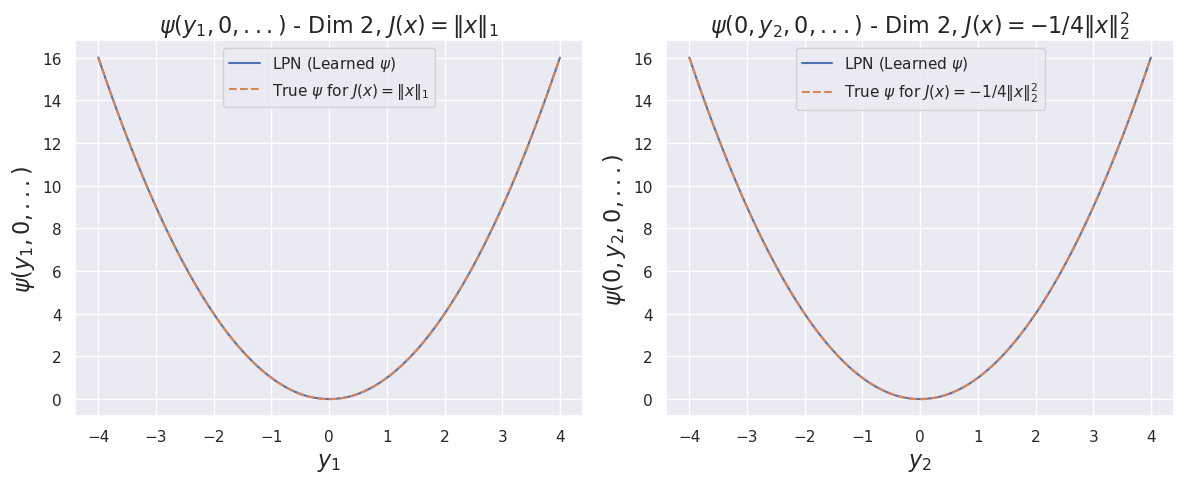

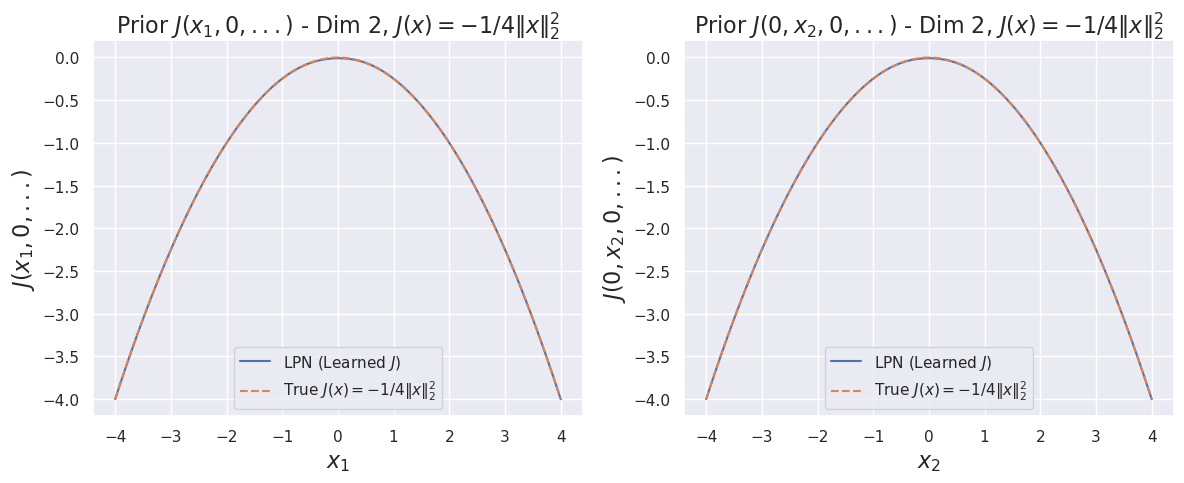

In [8]:
#print("\n--- Plotting Cross Sections for Quadratic H, Concave Quad Prior (Dim=4) ---")
plot_all_concave_quad(lpn_model_concave_quad_l2, a_exp, spacing, INVERT_MODE, dim_exp)

#print("\n--- Plotting Learned Hamiltonian for Quadratic H, Concave Quad Prior ---")
#evaluate_learned_H(lpn_model_concave_quad_l2, a_exp, spacing, dim_exp)

In [9]:
# --- Generate New Training Data for the Second LPN ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = y_j_exp_tensor.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model_concave_quad_l2.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model_concave_quad_l2(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)


tensor([[-1.3259,  3.5241],
        [-7.9881, -3.1604],
        [-5.6495, -6.5255],
        ...,
        [-5.3398,  1.8860],
        [-6.9098,  2.5440],
        [ 1.5267, -4.2261]], device='cuda:0')

In [10]:
# --- Train 2nd LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-3 
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 160.3020782470703
iteration 0 loss 3918.62548828125


iteration 500 loss 6.3739213943481445


iteration 1000 loss 0.7654561400413513


iteration 1500 loss 0.06713221967220306


iteration 2000 loss 0.023015156388282776


iteration 2500 loss 0.012844123877584934


iteration 3000 loss 0.007856907323002815


iteration 3500 loss 0.00491065951064229


iteration 4000 loss 0.007566150277853012


iteration 4500 loss 0.003852294757962227


iteration 5000 loss 0.0064901625737547874


iteration 5500 loss 0.002438487485051155


iteration 6000 loss 0.0027986580971628428


iteration 6500 loss 0.0019253265345469117


iteration 7000 loss 0.028010649606585503


iteration 7500 loss 0.001511809998191893


iteration 8000 loss 0.0011380212381482124


iteration 8500 loss 0.0012202851939946413


iteration 9000 loss 0.0018703967798501253


iteration 9500 loss 0.0008986034081317484


iteration 10000 loss 0.0010417537996545434


iteration 10500 loss 0.0006950943497940898


iteration 11000 loss 0.0007528660353273153


iteration 11500 loss 0.0012043569004163146


iteration 12000 loss 0.0005606615450233221


iteration 12500 loss 0.0005941979470662773


iteration 13000 loss 0.0007309847278520465


iteration 13500 loss 0.4448883533477783


iteration 14000 loss 0.0005250864778645337


iteration 14500 loss 0.01473600696772337


iteration 15000 loss 0.00043649462168104947


iteration 15500 loss 0.03511450067162514


iteration 16000 loss 0.0003973664715886116


iteration 16500 loss 0.0003077646251767874


iteration 17000 loss 0.00046968687092885375


iteration 17500 loss 0.00027852115454152226


iteration 18000 loss 0.0005598011775873601


iteration 18500 loss 0.000264297763351351


iteration 19000 loss 0.1506175547838211


iteration 19500 loss 0.0003485674678813666


iteration 20000 loss 0.00022651080507785082


iteration 20500 loss 0.001093616709113121


iteration 21000 loss 0.000324692897265777


iteration 21500 loss 0.00021253254089970142


iteration 22000 loss 0.00016501331992913038


iteration 22500 loss 0.00425347127020359


iteration 23000 loss 0.00027976935962215066


iteration 23500 loss 0.00020331032283138484


iteration 24000 loss 0.00016145715198945254


iteration 24500 loss 0.113801009953022


iteration 25000 loss 0.00025143742095679045


iteration 25500 loss 0.00016867375234141946


iteration 26000 loss 0.00013528639101423323


iteration 26500 loss 0.04464243724942207


iteration 27000 loss 0.00030743840034119785


iteration 27500 loss 0.00017116076196543872


iteration 28000 loss 0.00013302365550771356


iteration 28500 loss 0.00011295749573037028


iteration 29000 loss 0.014837493188679218


iteration 29500 loss 0.00021105939231347293


iteration 30000 loss 0.0001691350480541587


iteration 30500 loss 0.00020240239973645657


iteration 31000 loss 0.0001619157410459593


iteration 31500 loss 0.00013449032849166542


iteration 32000 loss 0.0001276363618671894


iteration 32500 loss 0.00010912242578342557


iteration 33000 loss 9.805377339944243e-05


iteration 33500 loss 8.758553303778172e-05


iteration 34000 loss 8.169341890607029e-05


iteration 34500 loss 7.58174792281352e-05


iteration 35000 loss 0.04660728946328163


iteration 35500 loss 7.541858940385282e-05


iteration 36000 loss 6.889418000355363e-05


iteration 36500 loss 6.966147338971496e-05


iteration 37000 loss 0.005961926653981209


iteration 37500 loss 0.0004358949663583189


iteration 38000 loss 0.0004166990693192929


iteration 38500 loss 0.00020474581106100231


iteration 39000 loss 0.0001517945056548342


iteration 39500 loss 0.00015709197032265365


iteration 40000 loss 0.0001493818563176319


iteration 40500 loss 0.00013604722335003316


iteration 41000 loss 0.00011650579835986719


iteration 41500 loss 9.71774134086445e-05


iteration 42000 loss 9.227284317603335e-05


iteration 42500 loss 0.0001297737326240167


iteration 43000 loss 0.00010888941324083135


iteration 43500 loss 0.00010674259101506323


iteration 44000 loss 9.923860488925129e-05


iteration 44500 loss 0.00014510123583022505


iteration 45000 loss 4.9001795559888706e-05


iteration 45500 loss 5.7960685808211565e-05


iteration 46000 loss 5.8491430536378175e-05


iteration 46500 loss 6.745367863913998e-05


iteration 47000 loss 0.0001262472796952352


iteration 47500 loss 0.025381674990057945


iteration 48000 loss 5.546228203456849e-05


iteration 48500 loss 5.484050416271202e-05


iteration 49000 loss 5.4186653869692236e-05


iteration 49500 loss 6.08961345278658e-05


iteration 50000 loss 8.832720050122589e-05


iteration 50500 loss 0.00015759665984660387


iteration 51000 loss 4.9518657760927454e-05


iteration 51500 loss 4.7751756937941536e-05


iteration 52000 loss 5.101588976685889e-05


iteration 52500 loss 8.176653500413522e-05


iteration 53000 loss 4.442320641828701e-05


iteration 53500 loss 5.607206549029797e-05


iteration 54000 loss 7.732654921710491e-05


iteration 54500 loss 7.723208545939997e-05


iteration 55000 loss 8.399878424825147e-05


iteration 55500 loss 0.00020183548622298986


iteration 56000 loss 0.1364738792181015


iteration 56500 loss 5.020800745114684e-05


iteration 57000 loss 5.717701787943952e-05


iteration 57500 loss 9.351166954729706e-05


iteration 58000 loss 4.779269147547893e-05


iteration 58500 loss 5.252086339169182e-05


iteration 59000 loss 5.691137266694568e-05


iteration 59500 loss 6.843911251053214e-05


iteration 60000 loss 4.37589296780061e-05


iteration 60500 loss 5.048973252996802e-05


iteration 61000 loss 0.00015951378736644983


iteration 61500 loss 4.335259654908441e-05


iteration 62000 loss 4.382486440590583e-05


iteration 62500 loss 4.8604011681163684e-05


iteration 63000 loss 8.568922203266993e-05


iteration 63500 loss 4.2114574171137065e-05


iteration 64000 loss 4.946219632984139e-05


iteration 64500 loss 0.0004436468007043004


iteration 65000 loss 4.289545177016407e-05


iteration 65500 loss 5.3651743655791506e-05


iteration 66000 loss 3.8675509131280705e-05


iteration 66500 loss 4.1512215830152854e-05


iteration 67000 loss 4.731267472379841e-05


iteration 67500 loss 0.00015231363067869097


iteration 68000 loss 4.1656032408354804e-05


iteration 68500 loss 4.767482096212916e-05


iteration 69000 loss 5.2433279051911086e-05


iteration 69500 loss 7.441863999702036e-05


iteration 70000 loss 0.1858874410390854


iteration 70500 loss 4.0543491195421666e-05


iteration 71000 loss 4.5325097744353116e-05


iteration 71500 loss 4.952923336531967e-05


iteration 72000 loss 5.3270232456270605e-05


iteration 72500 loss 5.1834547775797546e-05


iteration 73000 loss 5.707152376999147e-05


iteration 73500 loss 0.020376505330204964


iteration 74000 loss 3.590503183659166e-05


iteration 74500 loss 3.680069130496122e-05


iteration 75000 loss 3.9653437852393836e-05


iteration 75500 loss 4.685184103436768e-05


iteration 76000 loss 6.572694837814197e-05


iteration 76500 loss 3.441333319642581e-05


iteration 77000 loss 3.6329583963379264e-05


iteration 77500 loss 3.9921469578985125e-05


iteration 78000 loss 4.68410253233742e-05


iteration 78500 loss 0.00041110991151072085


iteration 79000 loss 3.404353992664255e-05


iteration 79500 loss 3.5035962355323136e-05


iteration 80000 loss 3.570284025045112e-05


iteration 80500 loss 3.707785435835831e-05


iteration 81000 loss 4.202811760478653e-05


iteration 81500 loss 6.988990935496986e-05


iteration 82000 loss 3.263596227043308e-05


iteration 82500 loss 3.334891880513169e-05


iteration 83000 loss 3.407202166272327e-05


iteration 83500 loss 3.615360037656501e-05


iteration 84000 loss 3.902484240825288e-05


iteration 84500 loss 4.327003989601508e-05


iteration 85000 loss 0.006390280555933714


iteration 85500 loss 3.224658576073125e-05


iteration 86000 loss 3.433616438996978e-05


iteration 86500 loss 3.637091867858544e-05


iteration 87000 loss 3.775839650188573e-05


iteration 87500 loss 4.279309359844774e-05


iteration 88000 loss 0.001430753618478775


iteration 88500 loss 3.126782030449249e-05


iteration 89000 loss 3.236104748793878e-05


iteration 89500 loss 3.3550542866578326e-05


iteration 90000 loss 4.020654159830883e-05


iteration 90500 loss 3.00294686894631e-05


iteration 91000 loss 3.079323869314976e-05


iteration 91500 loss 3.179837585776113e-05


iteration 92000 loss 3.292805195087567e-05


iteration 92500 loss 4.271197394700721e-05


iteration 93000 loss 2.8622507670661435e-05


iteration 93500 loss 2.9281680326675996e-05


iteration 94000 loss 3.0143730327836238e-05


iteration 94500 loss 3.381456190254539e-05


iteration 95000 loss 2.774486165435519e-05


iteration 95500 loss 2.867256262106821e-05


iteration 96000 loss 3.059838491026312e-05


iteration 96500 loss 0.027229705825448036


iteration 97000 loss 2.752573163888883e-05


iteration 97500 loss 2.8599535653484054e-05


iteration 98000 loss 3.0358301955857314e-05


iteration 98500 loss 4.925884059048258e-05


iteration 99000 loss 2.6525034627411515e-05


iteration 99500 loss 2.7094545657746494e-05


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 2.7561034585232846e-05


iteration 100500 loss 2.7112706447951496e-05


iteration 101000 loss 2.6635569156496786e-05


iteration 101500 loss 2.6120536858798005e-05


iteration 102000 loss 2.5561248548910953e-05


iteration 102500 loss 2.4951859813882038e-05


iteration 103000 loss 2.424137892376166e-05


iteration 103500 loss 2.3447390049113892e-05


iteration 104000 loss 2.2594536858377978e-05


iteration 104500 loss 2.1734624169766903e-05


iteration 105000 loss 2.1012678189435974e-05


iteration 105500 loss 2.035373472608626e-05


iteration 106000 loss 0.00013943834346719086


iteration 106500 loss 1.9164492186973803e-05


iteration 107000 loss 1.8775155695038848e-05


iteration 107500 loss 1.8125108908861876e-05


iteration 108000 loss 1.7663965991232544e-05


iteration 108500 loss 1.720133877824992e-05


iteration 109000 loss 1.678718217590358e-05


iteration 109500 loss 1.635694206925109e-05


iteration 110000 loss 1.604131466592662e-05


iteration 110500 loss 0.00011723091301973909


iteration 111000 loss 1.535164483357221e-05


iteration 111500 loss 1.5035572687338572e-05


iteration 112000 loss 2.4361559553653933e-05


iteration 112500 loss 1.4466093489318155e-05


iteration 113000 loss 1.4215152987162583e-05


iteration 113500 loss 1.3930341083323583e-05


iteration 114000 loss 1.368248831568053e-05


iteration 114500 loss 1.3468174074660055e-05


iteration 115000 loss 1.3208325981395319e-05


iteration 115500 loss 1.3000777471461333e-05


iteration 116000 loss 1.9592567696236074e-05


iteration 116500 loss 1.2569965292641427e-05


iteration 117000 loss 1.239119956153445e-05


iteration 117500 loss 1.2173036338936072e-05


iteration 118000 loss 1.2012384104309604e-05


iteration 118500 loss 1.194786364067113e-05


iteration 119000 loss 1.1657628419925459e-05


iteration 119500 loss 1.1507169801916461e-05


iteration 120000 loss 1.1318989891151432e-05


iteration 120500 loss 1.1176984116900712e-05


iteration 121000 loss 1.10335458884947e-05


iteration 121500 loss 7.251812348840758e-05


iteration 122000 loss 1.0731264410424046e-05


iteration 122500 loss 1.0604100680211559e-05


iteration 123000 loss 1.0533562090131454e-05


iteration 123500 loss 1.0326757546863519e-05


iteration 124000 loss 1.0216534974460956e-05


iteration 124500 loss 1.0432494491396938e-05


iteration 125000 loss 9.962523108697496e-06


iteration 125500 loss 9.855921234702691e-06


iteration 126000 loss 9.751036486704834e-06


iteration 126500 loss 9.620161108614411e-06


iteration 127000 loss 9.521629181108437e-06


iteration 127500 loss 9.424948075320572e-06


iteration 128000 loss 9.465456969337538e-06


iteration 128500 loss 9.216230864694808e-06


iteration 129000 loss 9.128589226747863e-06


iteration 129500 loss 9.043326826940756e-06


iteration 130000 loss 8.931982847570907e-06


iteration 130500 loss 8.852569408190902e-06


iteration 131000 loss 8.772897672315594e-06


iteration 131500 loss 2.2520540369441733e-05


iteration 132000 loss 8.599123248131946e-06


iteration 132500 loss 8.528259058948606e-06


iteration 133000 loss 8.58209932630416e-06


iteration 133500 loss 8.355724276043475e-06


iteration 134000 loss 8.28073279990349e-06


iteration 134500 loss 8.212292414100375e-06


iteration 135000 loss 8.142120350385085e-06


iteration 135500 loss 8.072498530964367e-06


iteration 136000 loss 8.005427844182122e-06


iteration 136500 loss 8.022625479497947e-06


iteration 137000 loss 0.00033827245351858437


iteration 137500 loss 7.788763468852267e-06


iteration 138000 loss 7.731838195468299e-06


iteration 138500 loss 7.677125722693745e-06


iteration 139000 loss 9.232440061168745e-05


iteration 139500 loss 7.548816483904375e-06


iteration 140000 loss 7.4928029789589345e-06


iteration 140500 loss 7.434989129251335e-06


iteration 141000 loss 7.380795068456791e-06


iteration 141500 loss 7.436632131430088e-06


iteration 142000 loss 6.124546052888036e-05


iteration 142500 loss 7.214798642962705e-06


iteration 143000 loss 7.155033927119803e-06


iteration 143500 loss 7.105557415343355e-06


iteration 144000 loss 7.056595222820761e-06


iteration 144500 loss 7.007543445070041e-06


iteration 145000 loss 6.959682650631294e-06


iteration 145500 loss 9.296471944253426e-06


iteration 146000 loss 6.851787020423217e-06


iteration 146500 loss 6.810289505665423e-06


iteration 147000 loss 6.7696710175368935e-06


iteration 147500 loss 6.732715519319754e-06


iteration 148000 loss 6.6726101977110375e-06


iteration 148500 loss 6.631748419749783e-06


iteration 149000 loss 6.591371402464574e-06


iteration 149500 loss 6.551727437908994e-06


iteration 150000 loss 6.513428616017336e-06


iteration 150500 loss 6.489646239060676e-06


iteration 151000 loss 0.00010970480070682243


iteration 151500 loss 6.392437171598431e-06


iteration 152000 loss 6.340922936942661e-06


iteration 152500 loss 6.3030552155396435e-06


iteration 153000 loss 6.26716973783914e-06


iteration 153500 loss 6.229655809875112e-06


iteration 154000 loss 6.192585715325549e-06


iteration 154500 loss 6.154607035568915e-06


iteration 155000 loss 6.119460522313602e-06


iteration 155500 loss 6.08384243605542e-06


iteration 156000 loss 6.0479569583549164e-06


iteration 156500 loss 6.013793154124869e-06


iteration 157000 loss 5.981447429803666e-06


iteration 157500 loss 5.945872544543818e-06


iteration 158000 loss 5.911460903007537e-06


iteration 158500 loss 5.880073331354652e-06


iteration 159000 loss 5.84785175306024e-06


iteration 159500 loss 5.815789336338639e-06


iteration 160000 loss 5.78476920054527e-06


iteration 160500 loss 5.754792709922185e-06


iteration 161000 loss 5.723629328713287e-06


iteration 161500 loss 5.692821559932781e-06


iteration 162000 loss 5.66244170840946e-06


iteration 162500 loss 5.6347721510974225e-06


iteration 163000 loss 5.605484602710931e-06


iteration 163500 loss 5.576591320277657e-06


iteration 164000 loss 5.547647106141085e-06


iteration 164500 loss 5.518710622709477e-06


iteration 165000 loss 5.489317118190229e-06


iteration 165500 loss 5.461306955112377e-06


iteration 166000 loss 5.4322708820109256e-06


iteration 166500 loss 5.403891918831505e-06


iteration 167000 loss 5.3768776524520945e-06


iteration 167500 loss 5.35058461537119e-06


iteration 168000 loss 5.325226993591059e-06


iteration 168500 loss 5.300854809320299e-06


iteration 169000 loss 5.273721399134956e-06


iteration 169500 loss 0.00015543476911261678


iteration 170000 loss 5.287327439873479e-06


iteration 170500 loss 5.200598934607115e-06


iteration 171000 loss 5.17467515237513e-06


iteration 171500 loss 5.149391199665843e-06


iteration 172000 loss 5.124417839397211e-06


iteration 172500 loss 5.1004863053094596e-06


iteration 173000 loss 5.076877641840838e-06


iteration 173500 loss 5.053713266534032e-06


iteration 174000 loss 5.029489784647012e-06


iteration 174500 loss 5.0042749535350595e-06


iteration 175000 loss 4.982384325558087e-06


iteration 175500 loss 3.8757942093070596e-05


iteration 176000 loss 1.5239989807014354e-05


iteration 176500 loss 4.936593541060574e-06


iteration 177000 loss 4.890448508376721e-06


iteration 177500 loss 4.869405529461801e-06


iteration 178000 loss 4.848008757107891e-06


iteration 178500 loss 4.826657914236421e-06


iteration 179000 loss 4.8047018026409205e-06


iteration 179500 loss 4.7831372285145335e-06


iteration 180000 loss 4.763443484989693e-06


iteration 180500 loss 4.742344572150614e-06


iteration 181000 loss 4.721532604889944e-06


iteration 181500 loss 4.701824309449876e-06


iteration 182000 loss 4.681279278884176e-06


iteration 182500 loss 4.661945240513887e-06


iteration 183000 loss 4.640729912352981e-06


iteration 183500 loss 4.6218387979024556e-06


iteration 184000 loss 4.600828560796799e-06


iteration 184500 loss 4.582623660098761e-06


iteration 185000 loss 4.5647111619473435e-06


iteration 185500 loss 4.5461943045665976e-06


iteration 186000 loss 4.545184310700279e-06


iteration 186500 loss 5.799123755423352e-06


iteration 187000 loss 1.3427433259494137e-05


iteration 187500 loss 4.464852736418834e-06


iteration 188000 loss 4.448375875654165e-06


iteration 188500 loss 4.430539775057696e-06


iteration 189000 loss 4.414061550050974e-06


iteration 189500 loss 4.398526925797341e-06


iteration 190000 loss 4.382462066132575e-06


iteration 190500 loss 4.3665118028002325e-06


iteration 191000 loss 4.354786142357625e-06


iteration 191500 loss 4.343977252574405e-06


iteration 192000 loss 1.1585242646106053e-05


iteration 192500 loss 4.344226908870041e-06


iteration 193000 loss 4.2953251977451146e-06


iteration 193500 loss 4.264813924237387e-06


iteration 194000 loss 4.248750883562025e-06


iteration 194500 loss 4.232115315971896e-06


iteration 195000 loss 4.216589786665281e-06


iteration 195500 loss 4.200472631055163e-06


iteration 196000 loss 4.183713826932944e-06


iteration 196500 loss 4.168107807345223e-06


iteration 197000 loss 4.152743713348173e-06


iteration 197500 loss 4.137689757044427e-06


iteration 198000 loss 4.12250165027217e-06


iteration 198500 loss 4.108026587346103e-06


iteration 199000 loss 4.093134975846624e-06


iteration 199500 loss 4.078507117810659e-06


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 4.064135737280594e-06


iteration 200500 loss 4.062479092681315e-06


iteration 201000 loss 4.059489583596587e-06


iteration 201500 loss 4.0557392821938265e-06


iteration 202000 loss 4.0514455577067565e-06


iteration 202500 loss 4.045637069793884e-06


iteration 203000 loss 4.038259248773102e-06


iteration 203500 loss 4.029603587696329e-06


iteration 204000 loss 4.018282197648659e-06


iteration 204500 loss 4.003632056992501e-06


iteration 205000 loss 5.799396149086533e-06


iteration 205500 loss 3.971610112785129e-06


iteration 206000 loss 1.2822031749237794e-05


iteration 206500 loss 3.941141585528385e-06


iteration 207000 loss 3.924954853573581e-06


iteration 207500 loss 3.910935447493102e-06


iteration 208000 loss 3.896078396792291e-06


iteration 208500 loss 3.881043994624633e-06


iteration 209000 loss 3.868156454700511e-06


iteration 209500 loss 3.8515158848895226e-06


iteration 210000 loss 3.839611963485368e-06


iteration 210500 loss 3.8247776501521e-06


iteration 211000 loss 3.811225269600982e-06


iteration 211500 loss 3.7967527077853447e-06


iteration 212000 loss 3.783731699513737e-06


iteration 212500 loss 3.7695435821660794e-06


iteration 213000 loss 3.7562629131571157e-06


iteration 213500 loss 3.74307614947611e-06


iteration 214000 loss 3.7298068491509184e-06


iteration 214500 loss 3.71661622011743e-06


iteration 215000 loss 3.7039048947917763e-06


iteration 215500 loss 3.690798394018202e-06


iteration 216000 loss 3.678296707221307e-06


iteration 216500 loss 3.665317535705981e-06


iteration 217000 loss 3.6529420412989566e-06


iteration 217500 loss 3.6399501368578058e-06


iteration 218000 loss 3.627952537499368e-06


iteration 218500 loss 3.847257630695822e-06


iteration 219000 loss 3.603428467613412e-06


iteration 219500 loss 3.5907162327930564e-06


iteration 220000 loss 3.5801051581074717e-06


iteration 220500 loss 3.5671068872034084e-06


iteration 221000 loss 3.556402589310892e-06


iteration 221500 loss 3.5442292301013367e-06


iteration 222000 loss 3.533493554641609e-06


iteration 222500 loss 3.5220357403886737e-06


iteration 223000 loss 3.511170234560268e-06


iteration 223500 loss 3.4994959605683107e-06


iteration 224000 loss 3.488510856186622e-06


iteration 224500 loss 3.4766903809213545e-06


iteration 225000 loss 3.4667900763452053e-06


iteration 225500 loss 3.454750640230486e-06


iteration 226000 loss 3.4449435588612687e-06


iteration 226500 loss 6.741928245901363e-06


iteration 227000 loss 3.423388307055575e-06


iteration 227500 loss 3.41451118401892e-06


iteration 228000 loss 3.4024290016532177e-06


iteration 228500 loss 3.391133077457198e-06


iteration 229000 loss 3.380439238753752e-06


iteration 229500 loss 3.3707424336171243e-06


iteration 230000 loss 3.3593012176424963e-06


iteration 230500 loss 3.350792667333735e-06


iteration 231000 loss 3.3403525776520837e-06


iteration 231500 loss 3.3311298466287553e-06


iteration 232000 loss 3.3208368677151157e-06


iteration 232500 loss 3.311288310214877e-06


iteration 233000 loss 3.3006931516865734e-06


iteration 233500 loss 3.2925993309618207e-06


iteration 234000 loss 3.2825796552060638e-06


iteration 234500 loss 3.2734851629356854e-06


iteration 235000 loss 3.26398185279686e-06


iteration 235500 loss 3.2548045965086203e-06


iteration 236000 loss 3.244915433242568e-06


iteration 236500 loss 3.2369091513828607e-06


iteration 237000 loss 3.227743718525744e-06


iteration 237500 loss 3.2185419058805564e-06


iteration 238000 loss 3.210105660400586e-06


iteration 238500 loss 3.2009443202696275e-06


iteration 239000 loss 3.1919391858536983e-06


iteration 239500 loss 3.183236685799784e-06


iteration 240000 loss 3.174792254867498e-06


iteration 240500 loss 3.1659378691983875e-06


iteration 241000 loss 3.1581541861669393e-06


iteration 241500 loss 3.6221547361492412e-06


iteration 242000 loss 3.1413908345712116e-06


iteration 242500 loss 3.1320246307586785e-06


iteration 243000 loss 3.124496288364753e-06


iteration 243500 loss 3.1155068427324295e-06


iteration 244000 loss 3.1080919598025503e-06


iteration 244500 loss 3.0994322059996193e-06


iteration 245000 loss 3.0918261018086923e-06


iteration 245500 loss 3.0839601095067337e-06


iteration 246000 loss 3.0760261324758176e-06


iteration 246500 loss 3.0681048883707263e-06


iteration 247000 loss 3.0599060210079188e-06


iteration 247500 loss 3.0529126888723113e-06


iteration 248000 loss 4.365492713986896e-06


iteration 248500 loss 3.037846454390092e-06


iteration 249000 loss 3.0297558168967953e-06


iteration 249500 loss 3.0224603051465238e-06


iteration 250000 loss 3.014745061591384e-06


iteration 250500 loss 3.0072881145315478e-06


iteration 251000 loss 2.999023536176537e-06


iteration 251500 loss 2.9925845410616603e-06


iteration 252000 loss 2.985111223097192e-06


iteration 252500 loss 2.977701569761848e-06


iteration 253000 loss 2.971293270093156e-06


iteration 253500 loss 3.0413095828407677e-06


iteration 254000 loss 2.9565635486505926e-06


iteration 254500 loss 2.9489435746654635e-06


iteration 255000 loss 2.942862238342059e-06


iteration 255500 loss 2.9354903290368384e-06


iteration 256000 loss 2.928792582679307e-06


iteration 256500 loss 2.921743543993216e-06


iteration 257000 loss 1.2661012988246512e-05


iteration 257500 loss 2.909153181462898e-06


iteration 258000 loss 2.901708739955211e-06


iteration 258500 loss 2.89535728370538e-06


iteration 259000 loss 2.8884373932669405e-06


iteration 259500 loss 2.8815709356422303e-06


iteration 260000 loss 2.875678546843119e-06


iteration 260500 loss 4.289626303943805e-06


iteration 261000 loss 2.8627182473428547e-06


iteration 261500 loss 2.8552735784614924e-06


iteration 262000 loss 2.8494741854956374e-06


iteration 262500 loss 2.843238689820282e-06


iteration 263000 loss 2.8370182008075062e-06


iteration 263500 loss 2.8304673378443113e-06


iteration 264000 loss 2.8240992833161727e-06


iteration 264500 loss 2.818093435053015e-06


iteration 265000 loss 2.811002332236967e-06


iteration 265500 loss 2.8056083465344273e-06


iteration 266000 loss 2.7995781692879973e-06


iteration 266500 loss 2.7935184334637597e-06


iteration 267000 loss 2.7875948944711126e-06


iteration 267500 loss 2.7812686766992556e-06


iteration 268000 loss 2.7755743303714553e-06


iteration 268500 loss 2.768521653706557e-06


iteration 269000 loss 2.7638864139589714e-06


iteration 269500 loss 2.7579183097259374e-06


iteration 270000 loss 2.752091631919029e-06


iteration 270500 loss 2.746362952166237e-06


iteration 271000 loss 2.9903935683250893e-06


iteration 271500 loss 2.734863755904371e-06


iteration 272000 loss 2.7284572752250824e-06


iteration 272500 loss 2.723274747040705e-06


iteration 273000 loss 2.717150209718966e-06


iteration 273500 loss 2.711710976655013e-06


iteration 274000 loss 2.7062585559178842e-06


iteration 274500 loss 2.702740857785102e-06


iteration 275000 loss 2.6950410756398924e-06


iteration 275500 loss 2.6887792046181858e-06


iteration 276000 loss 2.6838163194042863e-06


iteration 276500 loss 2.6784509827848524e-06


iteration 277000 loss 2.672964910743758e-06


iteration 277500 loss 2.6676550533011323e-06


iteration 278000 loss 2.8723654850182356e-06


iteration 278500 loss 2.6566765427560313e-06


iteration 279000 loss 2.6506747872190317e-06


iteration 279500 loss 2.64621849055402e-06


iteration 280000 loss 2.6408929443277884e-06


iteration 280500 loss 2.648015652084723e-06


iteration 281000 loss 2.630646349643939e-06


iteration 281500 loss 2.625408114909078e-06


iteration 282000 loss 2.6200661977782147e-06


iteration 282500 loss 2.6147172320634127e-06


iteration 283000 loss 2.6168927433900535e-06


iteration 283500 loss 2.604701194286463e-06


iteration 284000 loss 2.5989729692810215e-06


iteration 284500 loss 2.59434500549105e-06


iteration 285000 loss 2.5894498776324326e-06


iteration 285500 loss 2.584064759503235e-06


iteration 286000 loss 2.5794695375225274e-06


iteration 286500 loss 2.5735716917552054e-06


iteration 287000 loss 2.5694205305626383e-06


iteration 287500 loss 2.5645549612818286e-06


iteration 288000 loss 2.559426775405882e-06


iteration 288500 loss 2.5544068193994462e-06


iteration 289000 loss 2.676165877346648e-06


iteration 289500 loss 2.5449942313571228e-06


iteration 290000 loss 2.539195065764943e-06


iteration 290500 loss 2.5347317205159925e-06


iteration 291000 loss 2.529626726754941e-06


iteration 291500 loss 2.524767069189693e-06


iteration 292000 loss 2.520409907447174e-06


iteration 292500 loss 2.690732344490243e-06


iteration 293000 loss 2.5107058263529325e-06


iteration 293500 loss 2.505842985556228e-06


iteration 294000 loss 2.5012000151036773e-06


iteration 294500 loss 2.496384013284114e-06


iteration 295000 loss 2.4919006591517245e-06


iteration 295500 loss 2.4871455934771802e-06


iteration 296000 loss 2.4931155166996177e-06


iteration 296500 loss 2.4778535134828417e-06


iteration 297000 loss 2.4723101432755357e-06


iteration 297500 loss 2.4686066808499163e-06


iteration 298000 loss 2.4634748569951626e-06


iteration 298500 loss 2.458973540342413e-06


iteration 299000 loss 2.4542091523471754e-06


iteration 299500 loss 2.449542762406054e-06


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 2.4451978788420092e-06


iteration 300500 loss 2.4449568627460394e-06


iteration 301000 loss 2.4443181700917194e-06


iteration 301500 loss 2.443403218421736e-06


iteration 302000 loss 2.4423561626463197e-06


iteration 302500 loss 2.440858906993526e-06


iteration 303000 loss 2.4390533326368313e-06


iteration 303500 loss 2.436928298266139e-06


iteration 304000 loss 2.4338864932360593e-06


iteration 304500 loss 2.429875848974916e-06


iteration 305000 loss 2.4249395664810436e-06


iteration 305500 loss 2.4210885385400616e-06


iteration 306000 loss 2.4169496555259684e-06


iteration 306500 loss 2.4149633190972963e-06


iteration 307000 loss 2.40872986978502e-06


iteration 307500 loss 2.404464794381056e-06


iteration 308000 loss 2.3999948552955175e-06


iteration 308500 loss 2.395570618318743e-06


iteration 309000 loss 2.3910749860078795e-06


iteration 309500 loss 2.3874210910435067e-06


iteration 310000 loss 2.383004812145373e-06


iteration 310500 loss 2.3785232770023867e-06


iteration 311000 loss 2.375009898969438e-06


iteration 311500 loss 2.3706575120741036e-06


iteration 312000 loss 2.3666134438826703e-06


iteration 312500 loss 2.3632430838915752e-06


iteration 313000 loss 2.358920937695075e-06


iteration 313500 loss 2.354544676563819e-06


iteration 314000 loss 2.3513509859185433e-06


iteration 314500 loss 2.3470286123483675e-06


iteration 315000 loss 2.3426384814229095e-06


iteration 315500 loss 2.3392922230414115e-06


iteration 316000 loss 2.335078306714422e-06


iteration 316500 loss 2.3308459731197217e-06


iteration 317000 loss 2.3275313196791103e-06


iteration 317500 loss 2.3233419597090688e-06


iteration 318000 loss 2.318957058378146e-06


iteration 318500 loss 2.315902747795917e-06


iteration 319000 loss 2.311934167664731e-06


iteration 319500 loss 2.3074273940437706e-06


iteration 320000 loss 2.3043412511469796e-06


iteration 320500 loss 2.300318556081038e-06


iteration 321000 loss 2.295957074238686e-06


iteration 321500 loss 2.2929225451662205e-06


iteration 322000 loss 2.288777750436566e-06


iteration 322500 loss 2.2843596525490284e-06


iteration 323000 loss 2.2813314899394754e-06


iteration 323500 loss 2.277353132740245e-06


iteration 324000 loss 2.273302925459575e-06


iteration 324500 loss 2.270246568514267e-06


iteration 325000 loss 2.2663004983769497e-06


iteration 325500 loss 2.2621388779953122e-06


iteration 326000 loss 2.2588810679735616e-06


iteration 326500 loss 2.254856781291892e-06


iteration 327000 loss 2.2508527308673365e-06


iteration 327500 loss 2.247580596304033e-06


iteration 328000 loss 2.2434271613747114e-06


iteration 328500 loss 2.2399558474717196e-06


iteration 329000 loss 2.2367260044120485e-06


iteration 329500 loss 2.232610086139175e-06


iteration 330000 loss 2.228973471574136e-06


iteration 330500 loss 2.2253798306337558e-06


iteration 331000 loss 2.2210192582861055e-06


iteration 331500 loss 2.218082727267756e-06


iteration 332000 loss 2.2144113245303743e-06


iteration 332500 loss 2.210332468166598e-06


iteration 333000 loss 2.2073922991694417e-06


iteration 333500 loss 2.203748636020464e-06


iteration 334000 loss 2.1997529984219e-06


iteration 334500 loss 2.1966604890621966e-06


iteration 335000 loss 2.192451574956067e-06


iteration 335500 loss 2.1890732568863314e-06


iteration 336000 loss 2.1857783849554835e-06


iteration 336500 loss 2.1818211735080695e-06


iteration 337000 loss 2.178682962039602e-06


iteration 337500 loss 2.175292593165068e-06


iteration 338000 loss 2.7636888262350112e-06


iteration 338500 loss 2.168134869862115e-06


iteration 339000 loss 2.164837951568188e-06


iteration 339500 loss 2.160714984711376e-06


iteration 340000 loss 2.158022198273102e-06


iteration 340500 loss 2.154736648662947e-06


iteration 341000 loss 2.1602570541290333e-06


iteration 341500 loss 2.1476805613929173e-06


iteration 342000 loss 2.1441921944642672e-06


iteration 342500 loss 2.140294782293495e-06


iteration 343000 loss 2.1375697087933077e-06


iteration 343500 loss 2.1340961211535614e-06


iteration 344000 loss 2.1303883386281086e-06


iteration 344500 loss 2.127586640199297e-06


iteration 345000 loss 2.124104412359884e-06


iteration 345500 loss 2.120443241437897e-06


iteration 346000 loss 2.1178138922550716e-06


iteration 346500 loss 2.114347353199264e-06


iteration 347000 loss 2.1107016436872073e-06


iteration 347500 loss 2.1076305074529955e-06


iteration 348000 loss 2.103712631651433e-06


iteration 348500 loss 2.1010082491557114e-06


iteration 349000 loss 2.0979355213057715e-06


iteration 349500 loss 2.094233423122205e-06


iteration 350000 loss 2.0911952560709324e-06


iteration 350500 loss 2.0876875623798696e-06


iteration 351000 loss 2.0845366179855773e-06


iteration 351500 loss 2.081768798234407e-06


iteration 352000 loss 2.0780678369192174e-06


iteration 352500 loss 2.0751156171172624e-06


iteration 353000 loss 2.072075403702911e-06


iteration 353500 loss 2.0685929484898224e-06


iteration 354000 loss 2.065961098196567e-06


iteration 354500 loss 2.0628860966098728e-06


iteration 355000 loss 2.0591442080331035e-06


iteration 355500 loss 2.056518496829085e-06


iteration 356000 loss 2.0534016584861092e-06


iteration 356500 loss 2.0499628590187058e-06


iteration 357000 loss 2.047321004283731e-06


iteration 357500 loss 2.043970653176075e-06


iteration 358000 loss 2.0408749605849152e-06


iteration 358500 loss 2.038446837104857e-06


iteration 359000 loss 2.0351706098153954e-06


iteration 359500 loss 2.0320248950156383e-06


iteration 360000 loss 2.0289330677769613e-06


iteration 360500 loss 2.0255561139492784e-06


iteration 361000 loss 2.0226516426191665e-06


iteration 361500 loss 2.019337898673257e-06


iteration 362000 loss 2.0168768060102593e-06


iteration 362500 loss 2.013896164498874e-06


iteration 363000 loss 2.010648358918843e-06


iteration 363500 loss 2.0083436993445503e-06


iteration 364000 loss 2.0051975297974423e-06


iteration 364500 loss 2.0021013824589318e-06


iteration 365000 loss 1.9995800357719418e-06


iteration 365500 loss 1.9964666080340976e-06


iteration 366000 loss 1.993632622543373e-06


iteration 366500 loss 1.9902686290151905e-06


iteration 367000 loss 1.987725909202709e-06


iteration 367500 loss 1.9850629087159177e-06


iteration 368000 loss 1.9908563899662113e-06


iteration 368500 loss 1.979073431357392e-06


iteration 369000 loss 1.9758751932386076e-06


iteration 369500 loss 1.9733743101824075e-06


iteration 370000 loss 1.9702049485204043e-06


iteration 370500 loss 1.967544449144043e-06


iteration 371000 loss 1.9644483018055325e-06


iteration 371500 loss 1.9619033082562964e-06


iteration 372000 loss 1.959320798050612e-06


iteration 372500 loss 1.9560475266189314e-06


iteration 373000 loss 1.9537753814802272e-06


iteration 373500 loss 1.9509411686158273e-06


iteration 374000 loss 1.9480849005049095e-06


iteration 374500 loss 1.945505346157006e-06


iteration 375000 loss 1.942481731020962e-06


iteration 375500 loss 1.9400229120947188e-06


iteration 376000 loss 1.9375536339794053e-06


iteration 376500 loss 1.9346118733665207e-06


iteration 377000 loss 1.9322012576594716e-06


iteration 377500 loss 1.9298142888146685e-06


iteration 378000 loss 1.926507366079022e-06


iteration 378500 loss 1.924327989399899e-06


iteration 379000 loss 1.9220321973989485e-06


iteration 379500 loss 1.918805764944409e-06


iteration 380000 loss 1.916783958222368e-06


iteration 380500 loss 1.914153472171165e-06


iteration 381000 loss 1.9112146674160613e-06


iteration 381500 loss 1.9089725356025156e-06


iteration 382000 loss 1.9063511444983305e-06


iteration 382500 loss 1.903551947179949e-06


iteration 383000 loss 1.9012957181985257e-06


iteration 383500 loss 1.8982832443725783e-06


iteration 384000 loss 1.8960698753289762e-06


iteration 384500 loss 1.8936467540697777e-06


iteration 385000 loss 1.8905158185589244e-06


iteration 385500 loss 1.8885027657233877e-06


iteration 386000 loss 1.8861272792491945e-06


iteration 386500 loss 2.071694780170219e-06


iteration 387000 loss 1.8811042536981404e-06


iteration 387500 loss 1.8786690816341434e-06


iteration 388000 loss 1.8757480120257242e-06


iteration 388500 loss 1.873825453913014e-06


iteration 389000 loss 1.871245672191435e-06


iteration 389500 loss 1.86856789241574e-06


iteration 390000 loss 1.8663807850316516e-06


iteration 390500 loss 1.8636646927916445e-06


iteration 391000 loss 1.8611598306961241e-06


iteration 391500 loss 1.8590785657579545e-06


iteration 392000 loss 1.8564705897006206e-06


iteration 392500 loss 1.8541489907875075e-06


iteration 393000 loss 1.8520213416195475e-06


iteration 393500 loss 1.8491800801712088e-06


iteration 394000 loss 1.847024577728007e-06


iteration 394500 loss 1.8446849026076961e-06


iteration 395000 loss 1.8418155605104403e-06


iteration 395500 loss 1.840036361500097e-06


iteration 396000 loss 1.8377285186943482e-06


iteration 396500 loss 1.8349740003031911e-06


iteration 397000 loss 1.8330098328078748e-06


iteration 397500 loss 1.8304693867321475e-06


iteration 398000 loss 1.8277443132319604e-06


iteration 398500 loss 1.8258962199979578e-06


iteration 399000 loss 1.8234371736980393e-06


iteration 399500 loss 1.8210289454145823e-06


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 1.8189701904702815e-06


iteration 400500 loss 1.8187472505815094e-06


iteration 401000 loss 1.8184728105552495e-06


iteration 401500 loss 1.8182615804107627e-06


iteration 402000 loss 1.8178758409703732e-06


iteration 402500 loss 1.8171659803556395e-06


iteration 403000 loss 1.8164414541388396e-06


iteration 403500 loss 1.8153455130232032e-06


iteration 404000 loss 1.8141715827368898e-06


iteration 404500 loss 1.8125741689800634e-06


iteration 405000 loss 1.8105509980159695e-06


iteration 405500 loss 1.8082942006003577e-06


iteration 406000 loss 1.8059827198158018e-06


iteration 406500 loss 1.8039911537925946e-06


iteration 407000 loss 1.8018064338320983e-06


iteration 407500 loss 1.7994939298660029e-06


iteration 408000 loss 1.7976055914914468e-06


iteration 408500 loss 1.795319008124352e-06


iteration 409000 loss 1.7931840829987777e-06


iteration 409500 loss 1.79100891273265e-06


iteration 410000 loss 1.7890470189740881e-06


iteration 410500 loss 1.7869355133370846e-06


iteration 411000 loss 1.7849696405392024e-06


iteration 411500 loss 1.782729782462411e-06


iteration 412000 loss 1.7808040411182446e-06


iteration 412500 loss 1.7785474710763083e-06


iteration 413000 loss 1.7765888742360403e-06


iteration 413500 loss 1.774540919541323e-06


iteration 414000 loss 1.77262199940742e-06


iteration 414500 loss 1.7704128367768135e-06


iteration 415000 loss 1.7684664044281817e-06


iteration 415500 loss 1.7664730194155709e-06


iteration 416000 loss 1.7640536498220172e-06


iteration 416500 loss 1.7623736994210049e-06


iteration 417000 loss 1.760222289703961e-06


iteration 417500 loss 1.7582922282599611e-06


iteration 418000 loss 1.7561349068273557e-06


iteration 418500 loss 1.7544090269439039e-06


iteration 419000 loss 1.7522181678941706e-06


iteration 419500 loss 1.7503924709671992e-06


iteration 420000 loss 1.748360887177114e-06


iteration 420500 loss 1.7462957657699008e-06


iteration 421000 loss 1.7443663864469272e-06


iteration 421500 loss 1.7422659084331826e-06


iteration 422000 loss 1.7405682228854857e-06


iteration 422500 loss 1.7381898942403495e-06


iteration 423000 loss 1.7365823623549659e-06


iteration 423500 loss 1.7345226979159634e-06


iteration 424000 loss 1.732590362735209e-06


iteration 424500 loss 1.7306863355770474e-06


iteration 425000 loss 1.7286100728597376e-06


iteration 425500 loss 1.726454456729698e-06


iteration 426000 loss 1.7247615460291854e-06


iteration 426500 loss 1.7227127955266042e-06


iteration 427000 loss 1.7208207054864033e-06


iteration 427500 loss 1.7190400285471696e-06


iteration 428000 loss 1.7168293879876728e-06


iteration 428500 loss 1.715041435090825e-06


iteration 429000 loss 1.7132513221440604e-06


iteration 429500 loss 1.7111559600380133e-06


iteration 430000 loss 1.7093215092245373e-06


iteration 430500 loss 1.707505930426123e-06


iteration 431000 loss 1.705305180621508e-06


iteration 431500 loss 1.7036023791661137e-06


iteration 432000 loss 1.7015911453199806e-06


iteration 432500 loss 1.6999942999973428e-06


iteration 433000 loss 1.6978171970549738e-06


iteration 433500 loss 1.6960791526798857e-06


iteration 434000 loss 1.693886815701262e-06


iteration 434500 loss 1.6923007706282078e-06


iteration 435000 loss 1.6903414916669135e-06


iteration 435500 loss 1.6883404896361753e-06


iteration 436000 loss 1.686560494817968e-06


iteration 436500 loss 1.684786866462673e-06


iteration 437000 loss 1.6828141724545276e-06


iteration 437500 loss 1.6812726926218602e-06


iteration 438000 loss 1.678941316640703e-06


iteration 438500 loss 1.677407453826163e-06


iteration 439000 loss 1.6753874660935253e-06


iteration 439500 loss 1.6735892813812825e-06


iteration 440000 loss 1.6718621509426157e-06


iteration 440500 loss 1.6701172853572643e-06


iteration 441000 loss 1.6681417491781758e-06


iteration 441500 loss 1.6665364910295466e-06


iteration 442000 loss 1.6644384004393942e-06


iteration 442500 loss 1.66276652180386e-06


iteration 443000 loss 1.6606938970653573e-06


iteration 443500 loss 1.6589960978308227e-06


iteration 444000 loss 1.6571715377722285e-06


iteration 444500 loss 1.6552874058106681e-06


iteration 445000 loss 1.6537759393031592e-06


iteration 445500 loss 1.6516444247827167e-06


iteration 446000 loss 1.6499578805451165e-06


iteration 446500 loss 1.6483794524901896e-06


iteration 447000 loss 1.6463910696984385e-06


iteration 447500 loss 1.6447111192974262e-06


iteration 448000 loss 1.6428965636805515e-06


iteration 448500 loss 1.6409458112320863e-06


iteration 449000 loss 1.6393573787354399e-06


iteration 449500 loss 1.637459149606002e-06


iteration 450000 loss 1.6357969343516743e-06


iteration 450500 loss 1.6337945680788835e-06


iteration 451000 loss 1.63222694027354e-06


iteration 451500 loss 1.630331667001883e-06


iteration 452000 loss 1.6287326616293285e-06


iteration 452500 loss 1.626666062293225e-06


iteration 453000 loss 1.6254242609647918e-06


iteration 453500 loss 1.6231476820394164e-06


iteration 454000 loss 1.6214805782510666e-06


iteration 454500 loss 1.619978434064251e-06


iteration 455000 loss 1.6179633348656353e-06


iteration 455500 loss 1.6162925930984784e-06


iteration 456000 loss 1.614425627849414e-06


iteration 456500 loss 1.612962023500586e-06


iteration 457000 loss 1.6111092691062368e-06


iteration 457500 loss 1.609210585229448e-06


iteration 458000 loss 1.6075025541795185e-06


iteration 458500 loss 1.6058934306784067e-06


iteration 459000 loss 1.604064550519979e-06


iteration 459500 loss 1.602223619556753e-06


iteration 460000 loss 1.6006185887817992e-06


iteration 460500 loss 1.5989076018740889e-06


iteration 461000 loss 1.5970729236869374e-06


iteration 461500 loss 1.5954904029058525e-06


iteration 462000 loss 1.593752131157089e-06


iteration 462500 loss 1.5921469866952975e-06


iteration 463000 loss 1.5902187442407012e-06


iteration 463500 loss 1.588720465406368e-06


iteration 464000 loss 1.5869209164520726e-06


iteration 464500 loss 1.5850970385145047e-06


iteration 465000 loss 1.583306129759876e-06


iteration 465500 loss 1.5818899328223779e-06


iteration 466000 loss 1.5803628912181011e-06


iteration 466500 loss 1.5786484937052592e-06


iteration 467000 loss 1.5768013099659584e-06


iteration 467500 loss 1.5752676745250938e-06


iteration 468000 loss 1.5734120779598015e-06


iteration 468500 loss 1.5718832173661212e-06


iteration 469000 loss 1.5701547226854018e-06


iteration 469500 loss 1.5686172218920547e-06


iteration 470000 loss 1.567130539115169e-06


iteration 470500 loss 1.565305524309224e-06


iteration 471000 loss 1.5636398984497646e-06


iteration 471500 loss 1.5617445114912698e-06


iteration 472000 loss 1.5603761767124524e-06


iteration 472500 loss 1.5585426353936782e-06


iteration 473000 loss 1.5571619087495492e-06


iteration 473500 loss 1.555624407956202e-06


iteration 474000 loss 1.553918195895676e-06


iteration 474500 loss 1.5522016383329174e-06


iteration 475000 loss 1.5504460861848202e-06


iteration 475500 loss 1.5489520137634827e-06


iteration 476000 loss 1.5473431176360464e-06


iteration 476500 loss 1.5458820143976482e-06


iteration 477000 loss 1.544163978905999e-06


iteration 477500 loss 1.5427104926857282e-06


iteration 478000 loss 1.5410328160214704e-06


iteration 478500 loss 1.5394365391330211e-06


iteration 479000 loss 1.539228719593666e-06


iteration 479500 loss 1.53628104726522e-06


iteration 480000 loss 1.5346001873695059e-06


iteration 480500 loss 1.533202635073394e-06


iteration 481000 loss 1.5315285963879433e-06


iteration 481500 loss 1.5299199276341824e-06


iteration 482000 loss 1.5282249705705908e-06


iteration 482500 loss 1.5266767832144978e-06


iteration 483000 loss 1.5251901004376123e-06


iteration 483500 loss 1.5235278851832845e-06


iteration 484000 loss 1.5221160083456198e-06


iteration 484500 loss 1.520534283372399e-06


iteration 485000 loss 1.5191045577012119e-06


iteration 485500 loss 1.5174483678492834e-06


iteration 486000 loss 1.5158626638367423e-06


iteration 486500 loss 1.514399968982616e-06


iteration 487000 loss 1.5128650829865364e-06


iteration 487500 loss 1.511511868557136e-06


iteration 488000 loss 1.5098557923920453e-06


iteration 488500 loss 1.508361265223357e-06


iteration 489000 loss 1.506715420873661e-06


iteration 489500 loss 1.5052750086397282e-06


iteration 490000 loss 1.5037204548207228e-06


iteration 490500 loss 1.5021020089989179e-06


iteration 491000 loss 1.5005889508756809e-06


iteration 491500 loss 1.4990606587161892e-06


iteration 492000 loss 1.4975379372117459e-06


iteration 492500 loss 1.4962887462388608e-06


iteration 493000 loss 1.4946790543035604e-06


iteration 493500 loss 1.4931168834664277e-06


iteration 494000 loss 1.491570174039225e-06


iteration 494500 loss 1.4900861060596071e-06


iteration 495000 loss 1.4885779364703922e-06


iteration 495500 loss 1.4872725841996726e-06


iteration 496000 loss 1.4856401548968279e-06


iteration 496500 loss 1.4841851907476666e-06


iteration 497000 loss 1.4826752021690481e-06


iteration 497500 loss 1.4813211919317837e-06


iteration 498000 loss 1.47985986131971e-06


iteration 498500 loss 1.4785190387556213e-06


iteration 499000 loss 1.4767967968509765e-06


iteration 499500 loss 1.475358317293285e-06


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from LPN 2 ---


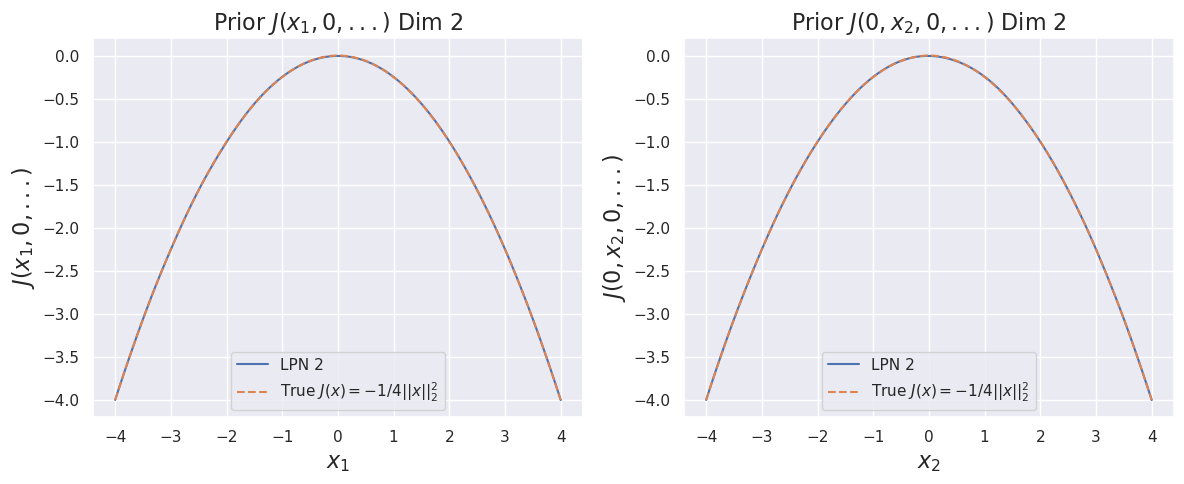

In [11]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from LPN 2 ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('$J(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ Dim {dim}",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('$J(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)